In [1]:
# first, import libs needed for data analysis
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from copy import copy

if 'Datasets' not in os.listdir():
    os.chdir('../')

In [2]:
dataset = 'Walmart'
with open('config/dates.txt') as f:
    t = f.read().splitlines()
key = True
dates = {}
for e in t:
    if key:
        dates[e] = []
        ckey = e
        key = False
        continue
    elif e == '':
        key = True
        continue
    else:
        dates[ckey].append(e)
        
test_dates = dates[dataset]  
test_dates = pd.to_datetime(test_dates)
test_dates

DatetimeIndex(['2015-12-01', '2016-01-01', '2016-02-01', '2016-03-01',
               '2016-04-01'],
              dtype='datetime64[ns]', freq=None)

In [3]:
week_length = 7
encoder_length = week_length * 2
decoder_length = week_length * 2
seq_thresh = 7
# _______________________________________________


In [4]:
data = pd.read_csv('Datasets/Walmart/sales_train_evaluation.csv')
prices = pd.read_csv('Datasets/Walmart/sell_prices.csv')
cal = pd.read_csv('Datasets/Walmart/calendar.csv')

In [5]:
# _______________________________________________

replacer = {'item_id':'art',
            'store_id':'pos',
            'dept_id':'dept',
            'cat_id':'cat',
            'state_id':'state',}

data = data.rename(columns=replacer)
data = data.drop('id', axis=1)

prices = prices.rename(columns=replacer)
# _______________________________________________

In [6]:
data[['art','pos']].nunique()

art    3049
pos      10
dtype: int64

In [7]:
data = data[data['cat'].str.contains('FOODS')]
art_info = data.iloc[:,:5].drop_duplicates()
data = data.iloc[:,5:].T
data.columns = art_info.set_index(['art','pos']).index

prices = prices.merge(cal[['wm_yr_wk','date']], on='wm_yr_wk', how='left').drop('wm_yr_wk', axis=1)
prices['date'] = pd.to_datetime(prices['date'])
priceswide = prices.pivot_table(index='date',columns=['art','pos'],values='sell_price').fillna(method='ffill').fillna(method='bfill')

cal['date'] = pd.to_datetime(cal['date'])
data.index = data.index.map(cal.set_index('d')['date'])

In [8]:
# add month
def add_month(date):
    if date.month == 12:
        return date.replace(year=date.year+1, month=1, day=1)
    else:
        return date.replace(month=date.month+1, day=1)
    
all_test_dates = []
for d in test_dates:
    all_test_dates += pd.date_range(start=d,end=add_month(d),freq='D').tolist()

all_test_dates = [d for d in all_test_dates if d in data.index]

all_dates = copy(all_test_dates)
for d in test_dates:
    all_dates += pd.date_range(d-pd.Timedelta(days=100),freq='D',periods=100).tolist()

all_dates = list(set(all_dates))

In [9]:
sales_pivoted = data.loc[:max(all_dates)]

In [10]:
# remove if zero sequences in test set
sales_pivoted.index.name = 'date'
zs = 100
zero_seq_long_rev = sales_pivoted.asfreq('D').fillna(0).iloc[::-1].eq(0).rolling(zs).sum().loc[sales_pivoted.index]
zero_seq_long = sales_pivoted.asfreq('D').fillna(0).eq(0).rolling(zs).sum()
zero_mask = (zero_seq_long + zero_seq_long_rev).ge(zs+1)
zero_mask = zero_mask.replace(False, np.nan).bfill().fillna(False)

sales_pivoted[zero_mask] = np.nan


mask_nan = sales_pivoted.asfreq('D').replace(0,np.nan)
mask_nan[mask_nan.ffill().notnull()] = 0
mask_nan = mask_nan.fillna(1).astype(bool)

full_mask = mask_nan | zero_mask

sales_pivoted = sales_pivoted.asfreq('D').fillna(0)
sales_pivoted[full_mask] = np.nan


/var/folders/0f/01zw64517cqdsbtf53d86j7h0000gn/T/ipykernel_65785/476194638.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sales_pivoted[zero_mask] = np.nan
/var/folders/0f/01zw64517cqdsbtf53d86j7h0000gn/T/ipykernel_65785/476194638.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sales_pivoted[zero_mask] = np.nan


In [11]:
s = sales_pivoted.loc[all_dates].notnull().mean()
s = s[s==1].index
sales_pivoted = sales_pivoted[s]

# top 500 revenue
revenues = sales_pivoted.loc[all_dates,s] * priceswide.loc[all_dates,s]
r = revenues.sum().sort_values() / revenues.sum().max()
r = r.tail(500).index

# top 500 sales
a = sales_pivoted.loc[all_dates,s].sum().sort_values() / sales_pivoted.loc[all_dates,s].sum().max()
a = a.tail(500).index

# median sales of > 3
m = sales_pivoted.loc[all_dates,s].median()
m = m[m>5].index

# remove if zero sequences in test set
zs = week_length
zero_seq_rev = sales_pivoted.iloc[::-1].eq(0).rolling(zs).sum().loc[sales_pivoted.index]
zero_seq = sales_pivoted.eq(0).rolling(zs).sum()
zero_seq = (zero_seq + zero_seq_rev).eq(zs+1)
z = ~ zero_seq.loc[all_test_dates].any(axis=0)
z = z[z].index

sel = r.intersection(a).intersection(m).intersection(z)

print(len(sel))

221


In [12]:
# data = data[intersection]
data = sales_pivoted[sel].melt(ignore_index=False, value_name='sales').dropna()

In [13]:
data = data.reset_index()

In [14]:
mapping = pd.Series(data['date'].unique())
mapping.index = mapping.values
mapping = mapping.rank().astype(int)

data['time_idx'] = data['date'].map(mapping)
test_idx = [mapping.loc[d] for d in test_dates]


In [15]:
holiday = cal[['date','event_type_1','event_name_1','event_type_2','event_name_2']]

hdays = pd.DataFrame()
htypes = list(holiday[['event_type_1','event_type_2']].melt()['value'].dropna().unique())
for htype in htypes:
    h1 = holiday.query('event_type_1 == @htype')[['date','event_name_1']].dropna().rename(columns={'event_name_1':htype})
    h2 = holiday.query('event_type_2 == @htype')[['date','event_name_2']].dropna().rename(columns={'event_name_2':htype})
    h = pd.concat([h1,h2],axis=0).set_index('date')
    hdays = pd.concat([hdays,h],axis=1)
    

In [16]:
data = data.merge(cal[['date','snap_CA','snap_TX','snap_WI']], on='date', how='left')
data[['snap_CA','snap_TX','snap_WI']] = data[['snap_CA','snap_TX','snap_WI']].apply(lambda x: x.map({0: '._.', 1: x.name.split('_')[1]}))
snap = ((data['pos'].apply(lambda x:x.split('_')[0]) == data['snap_CA']) | (data['pos'].apply(lambda x:x.split('_')[0]) == data['snap_TX']) | (data['pos'].apply(lambda x:x.split('_')[0]) == data['snap_WI']))
data['snap'] = snap.replace(False,np.nan)
data = data.drop(['snap_CA','snap_TX','snap_WI'],axis=1)

In [17]:
prices = priceswide[sales_pivoted.columns].melt(ignore_index=False,value_name='price')
data = data.merge(prices, on=['date','art','pos'], how='left')
data = data.merge(art_info,on=['art','pos'],how='left')
data = data.merge(hdays,on='date',how='left')

data['closed'] = (data.groupby(['date','pos'])['sales'].transform('sum') < 50).replace(False,np.nan)
data['weekday'] = data['date'].dt.weekday.astype(str)



cats = ['art','pos','dept','cat','state','snap','closed','weekday'] + htypes
for c in cats:
    data[c] = data[c].replace(True,'x').replace(False,'-')
    data[c] = data[c].replace(1,'x').replace(0,'-')
    data[c] = data[c].replace(np.nan,'-')
    data[c] = data[c].astype('category')

# convert all numerical columns to float 32
for c in data.select_dtypes('number').columns:
    data[c] = data[c].astype('float32')
    
data['time_idx'] = data['time_idx'].astype(int)
# columns = data.select_dtypes('datetime').columns.append(
#     data.select_dtypes('number').columns).append(
#         data.select_dtypes('category').columns)

data['time_series'] = data['art'].astype(str)+'_' + data['pos'].astype(str)
data = data.sort_values(['time_series','time_idx'])
data['relprice'] = data.groupby('time_series')['price'].rolling(30).mean().bfill().values
data['relprice'] = data['price'] / data['relprice'] - 1
data['relprice'] = data['relprice'].fillna(0)

# data = data[columns]
data['dayofyear'] = data['date'].dt.dayofyear.astype(str)
data['weekofyear'] = data['date'].dt.isocalendar().week.astype(str)


data['snap'] = data['snap'].astype(str)
sales_pivoted = data.pivot_table(index='date',columns=['art','pos'],values='sales')
for c in data.columns:
    data.rename(columns={c:c.replace(' ','').replace('-','').replace("'",'')},inplace=True)
    
data['storesales'] = data.groupby(['date','pos'])['sales'].transform('sum')
data = data[data.storesales > 0]

data['day_of_year'] = data['date'].dt.dayofyear
data['doy_sine'] = np.sin(2 * np.pi * data['day_of_year'] / 365.25)
data['doy_cosine'] = np.cos(2 * np.pi * data['day_of_year'] / 365.25)
data['year'] = data['date'].dt.year

In [18]:
data.to_pickle('Processed/Walmart/walmart_data.pkl')

In [19]:
data.groupby('date')['time_idx'].mean().diff().dropna().eq(1).all()

True

In [20]:
for c in sales_pivoted.columns:
    series = sales_pivoted[c].dropna()
    if series.iloc[0] == 0:
        print(c)

('FOODS_1_012', 'CA_2')


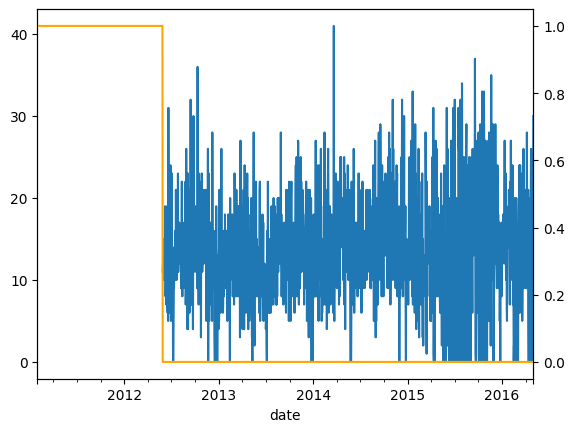

('FOODS_1_012', 'TX_2')


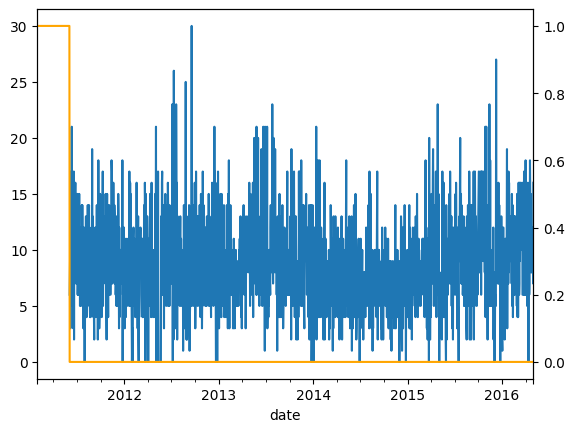

('FOODS_1_012', 'TX_3')


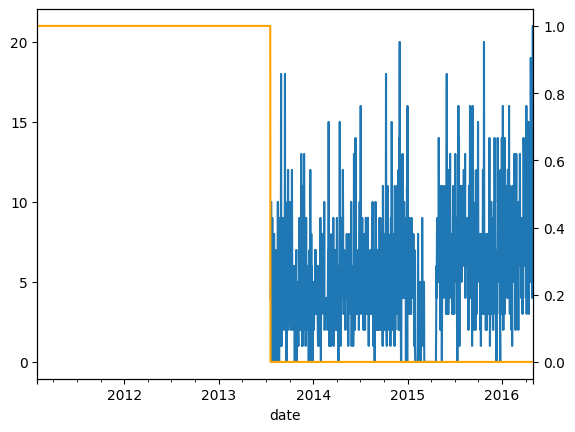

('FOODS_1_096', 'TX_3')


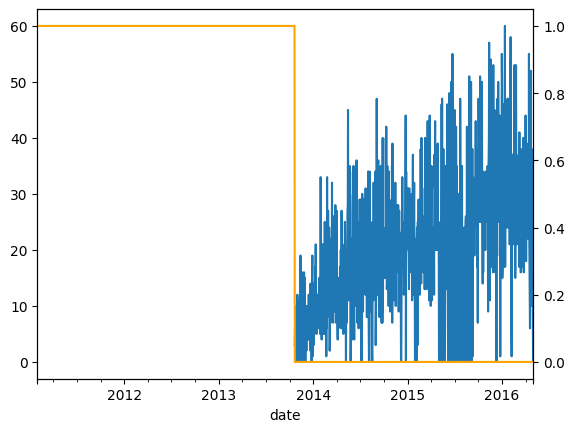

('FOODS_1_096', 'WI_2')


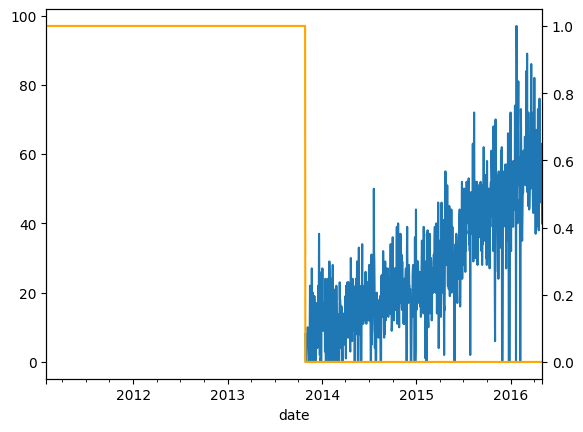

('FOODS_1_170', 'CA_2')


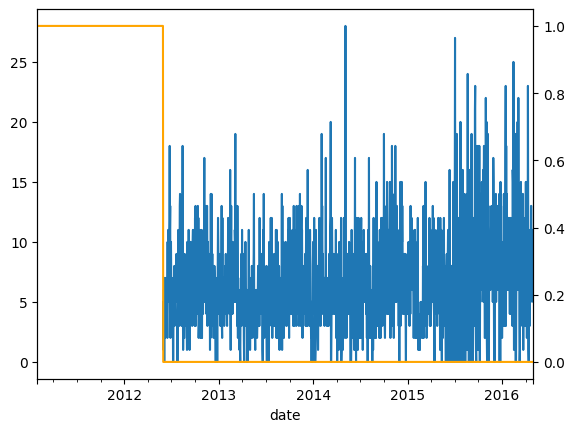

('FOODS_1_170', 'CA_3')


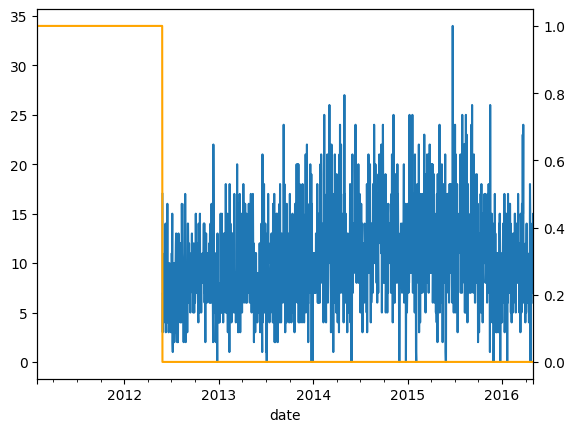

('FOODS_1_217', 'CA_3')


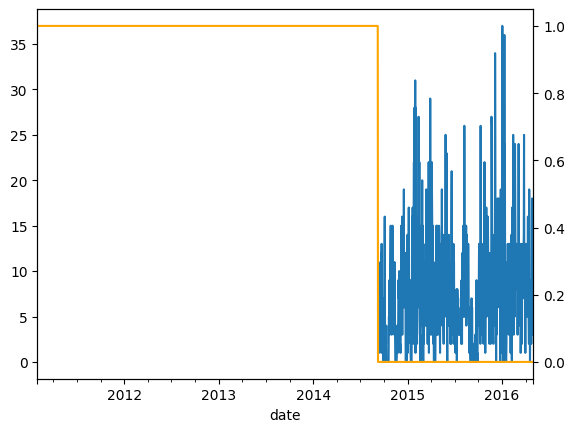

('FOODS_2_019', 'CA_1')


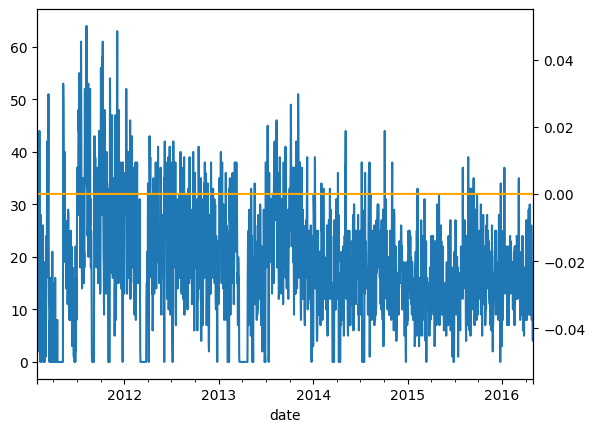

('FOODS_2_019', 'CA_3')


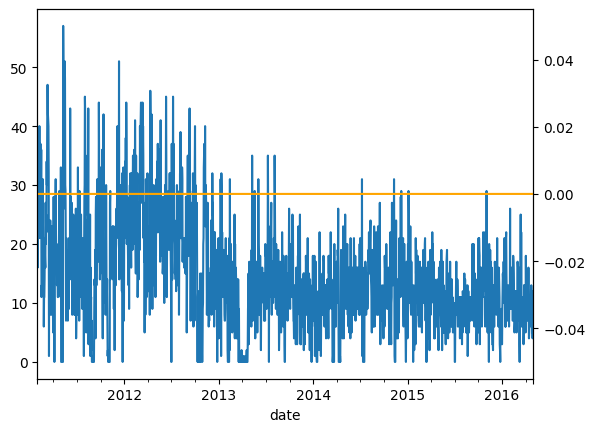

('FOODS_2_056', 'WI_2')


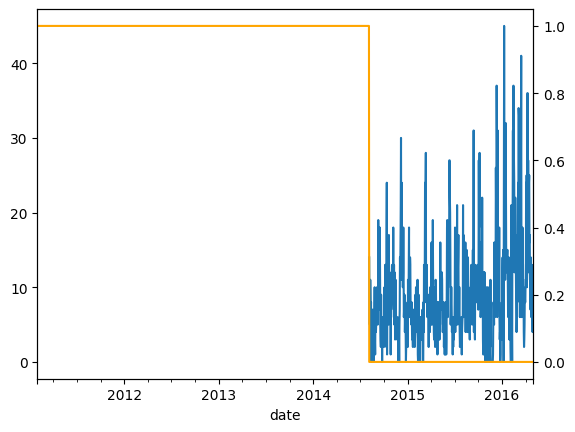

('FOODS_2_152', 'TX_2')


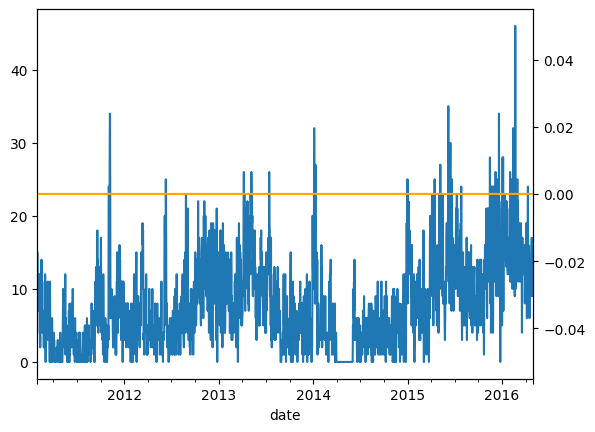

('FOODS_2_164', 'WI_2')


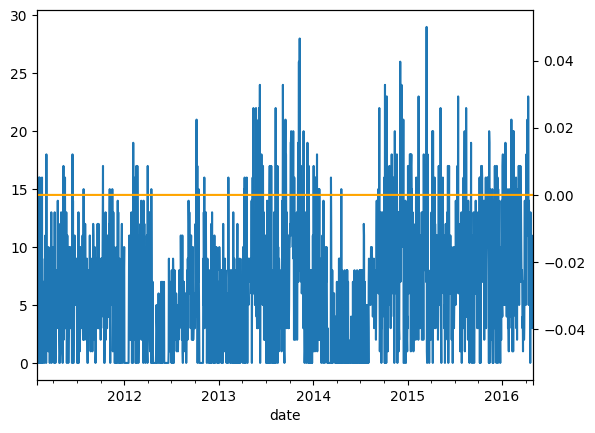

('FOODS_2_175', 'WI_2')


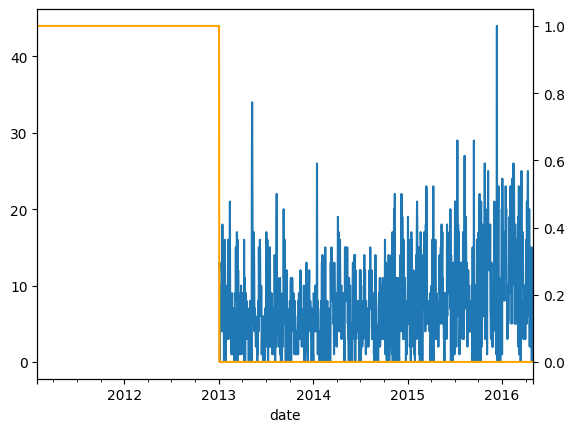

('FOODS_2_181', 'TX_1')


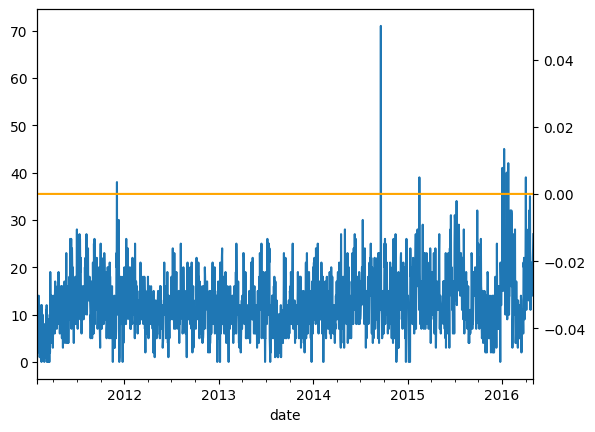

('FOODS_2_181', 'TX_2')


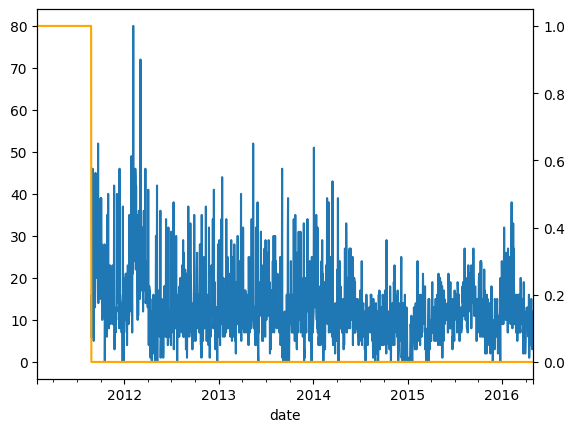

('FOODS_2_197', 'CA_1')


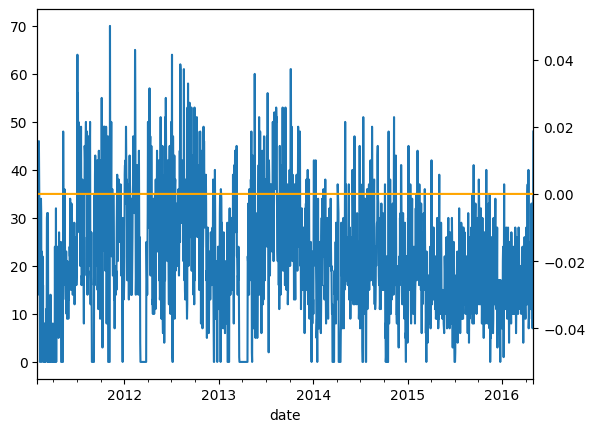

('FOODS_2_197', 'CA_3')


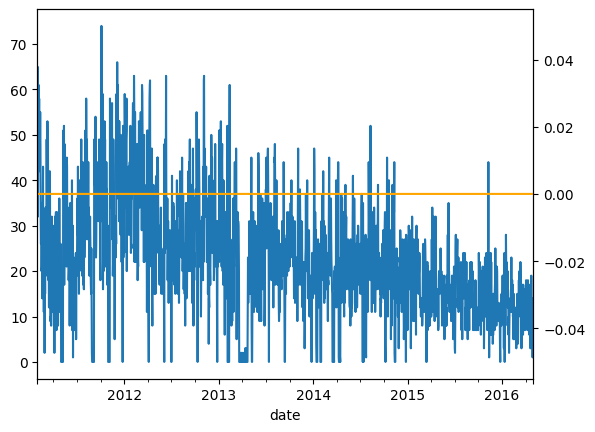

('FOODS_2_197', 'CA_4')


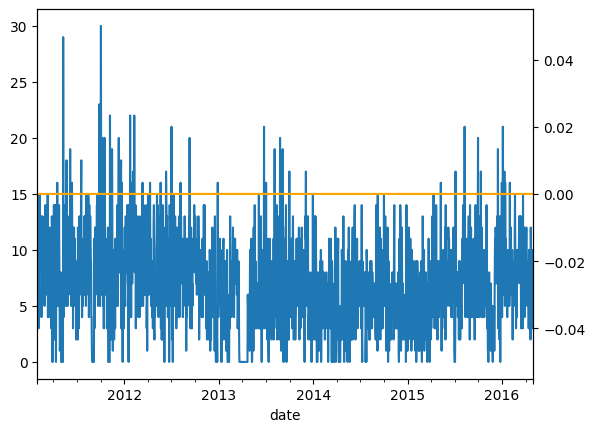

('FOODS_2_222', 'CA_1')


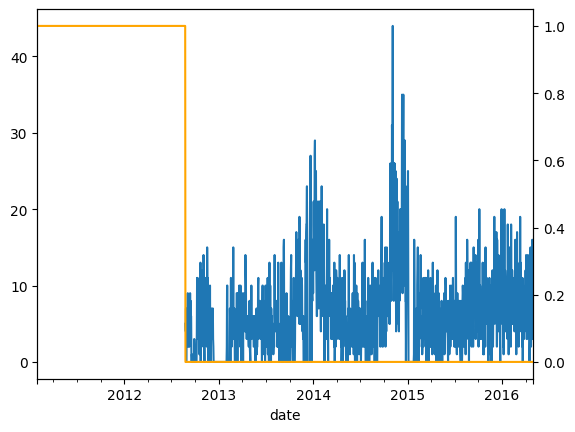

('FOODS_2_222', 'CA_4')


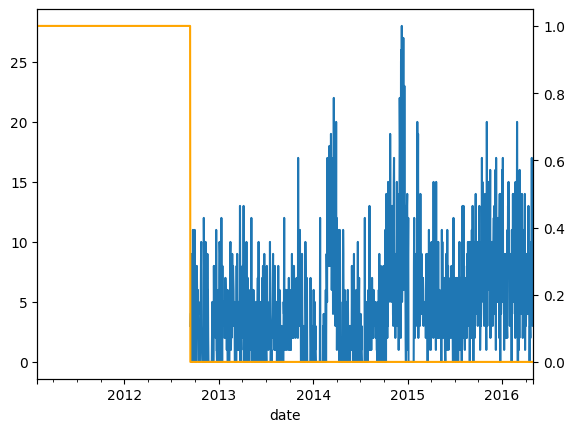

('FOODS_2_222', 'WI_1')


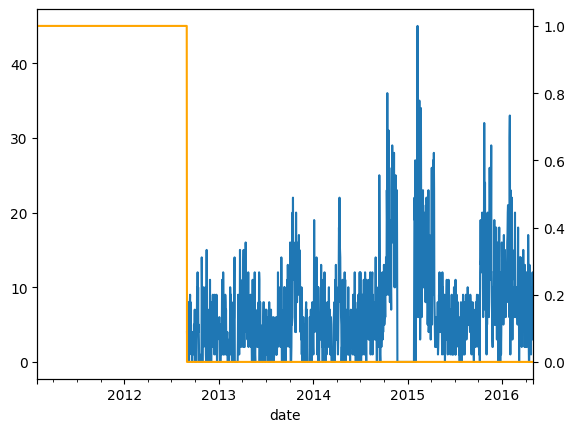

('FOODS_2_222', 'WI_2')


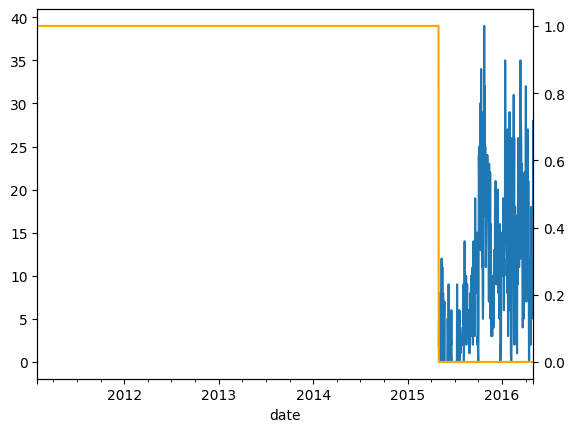

('FOODS_2_241', 'CA_3')


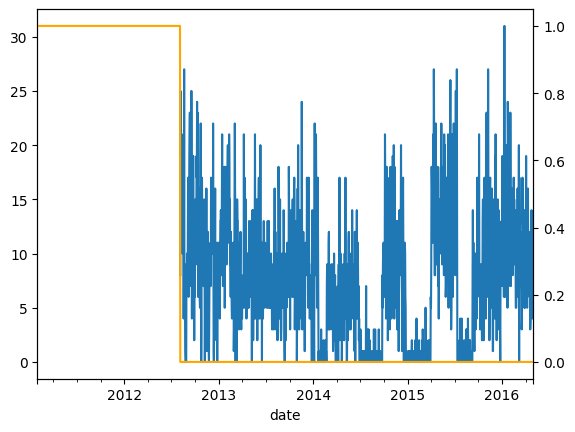

('FOODS_2_244', 'CA_3')


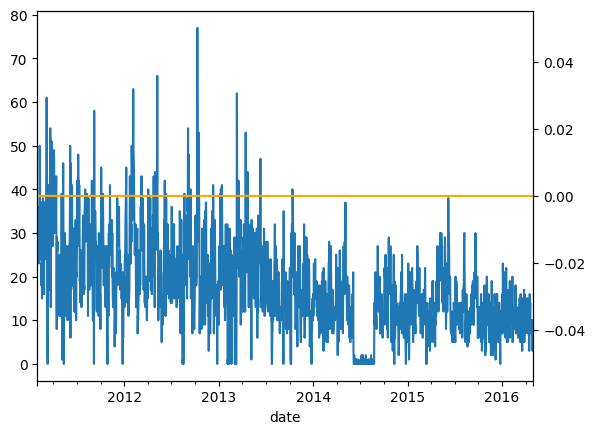

('FOODS_2_276', 'CA_1')


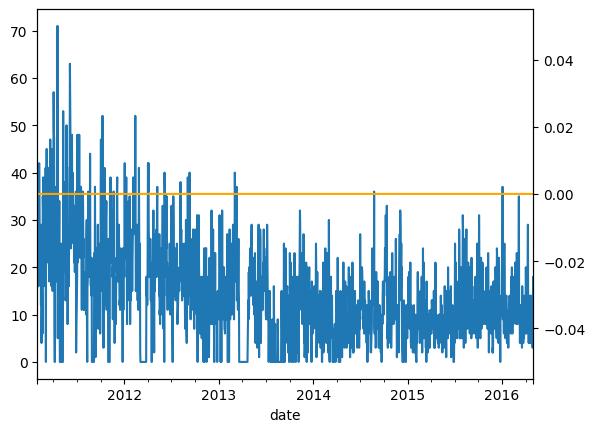

('FOODS_2_276', 'WI_2')


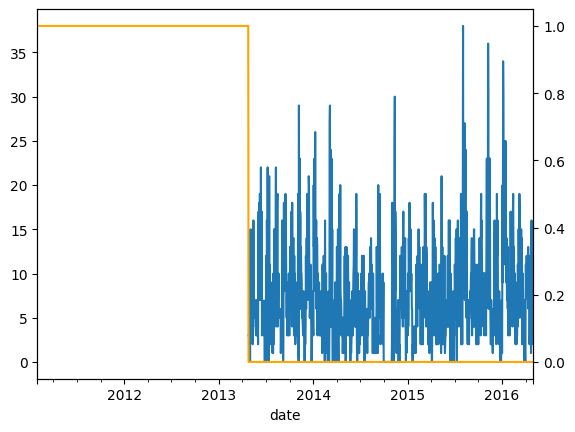

('FOODS_2_285', 'WI_2')


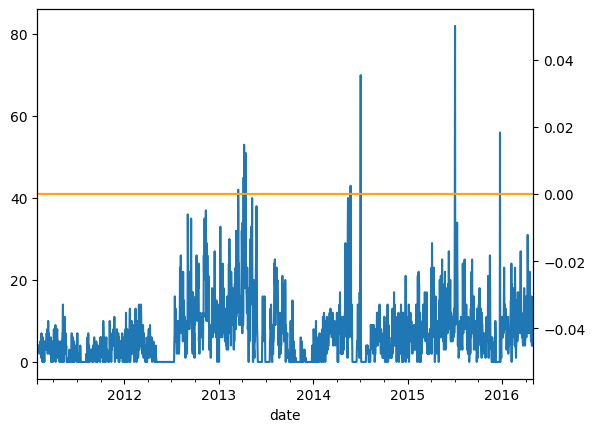

('FOODS_2_318', 'CA_3')


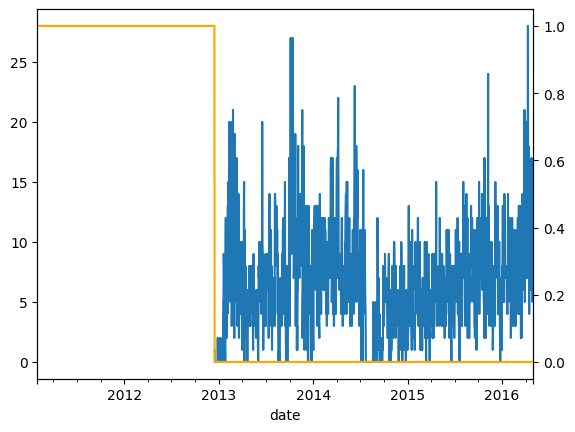

('FOODS_2_326', 'WI_2')


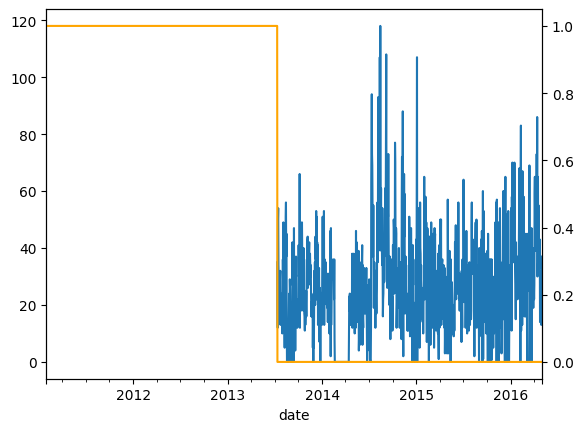

('FOODS_2_347', 'CA_3')


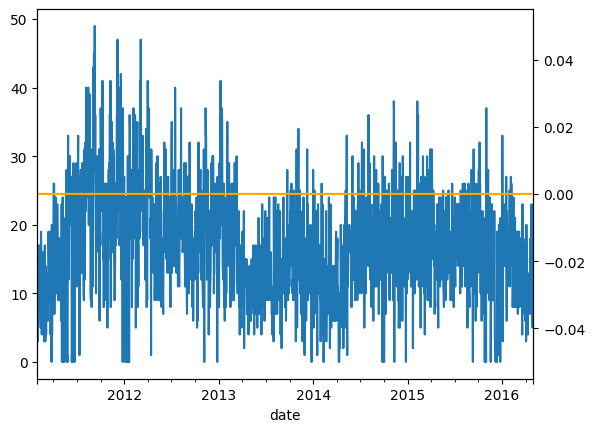

('FOODS_2_368', 'WI_2')


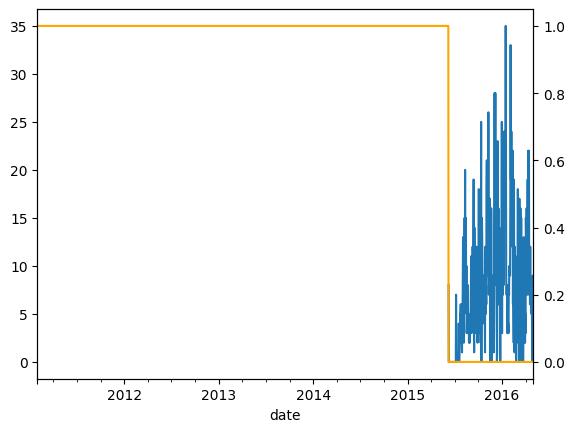

('FOODS_2_380', 'WI_2')


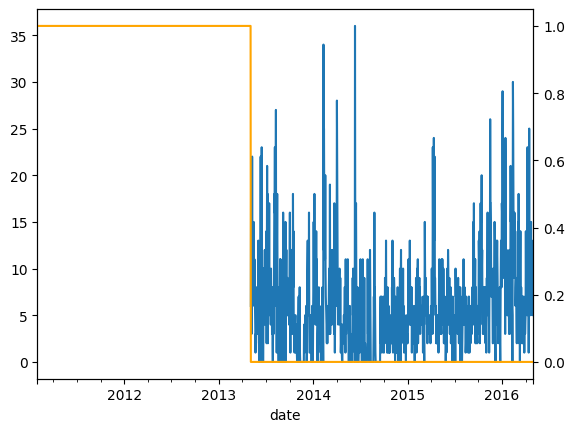

('FOODS_2_398', 'WI_1')


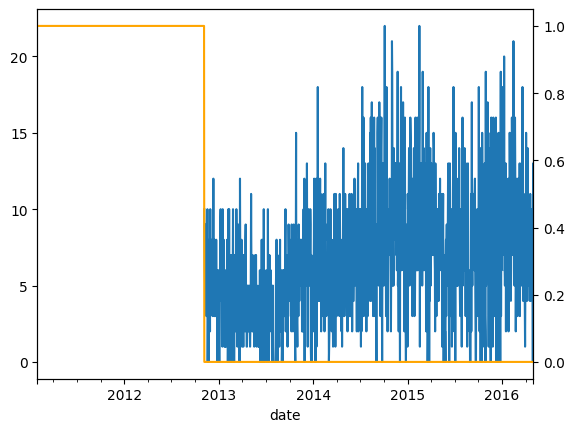

('FOODS_3_042', 'WI_1')


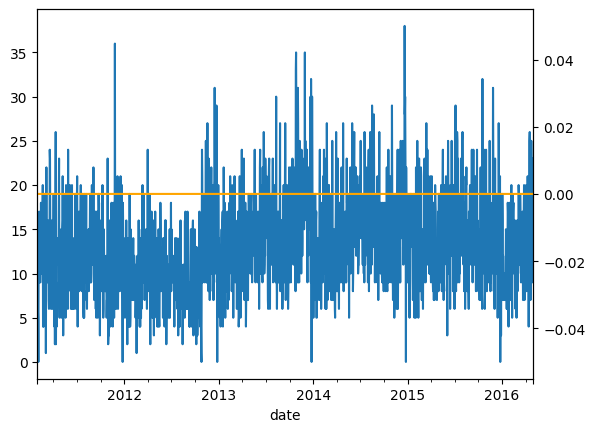

('FOODS_3_064', 'CA_1')


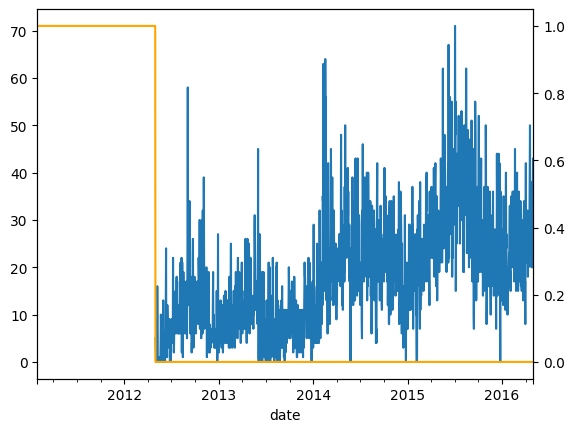

('FOODS_3_066', 'CA_2')


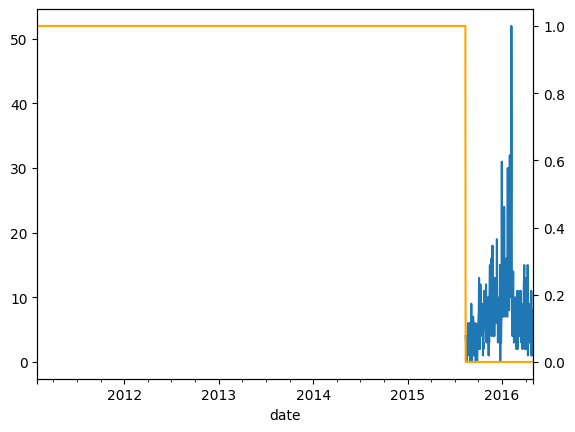

('FOODS_3_066', 'CA_3')


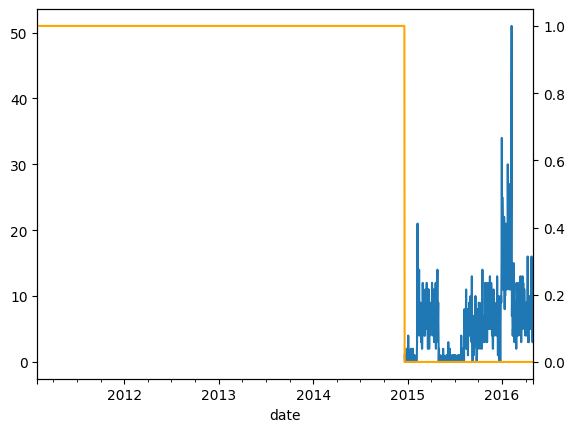

('FOODS_3_080', 'CA_1')


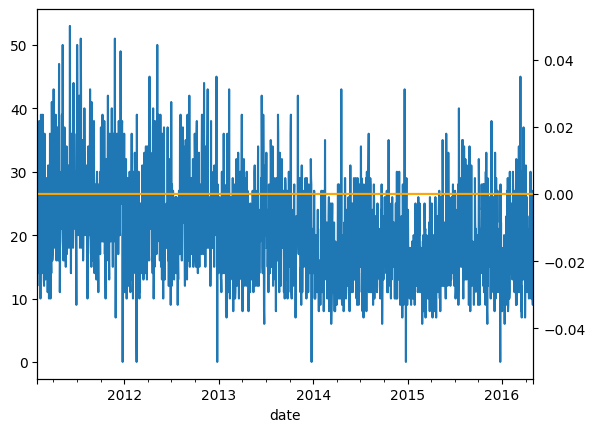

('FOODS_3_080', 'CA_2')


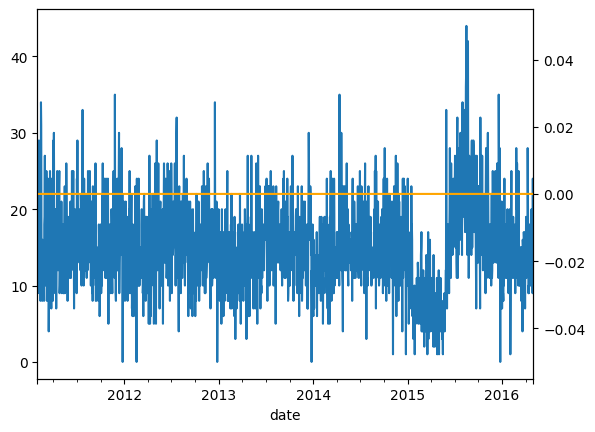

('FOODS_3_080', 'CA_3')


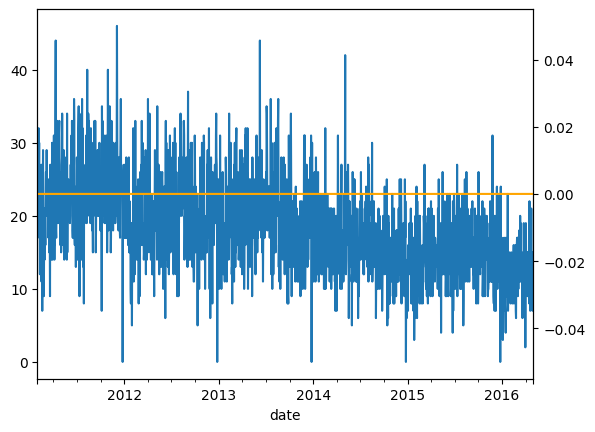

('FOODS_3_080', 'TX_2')


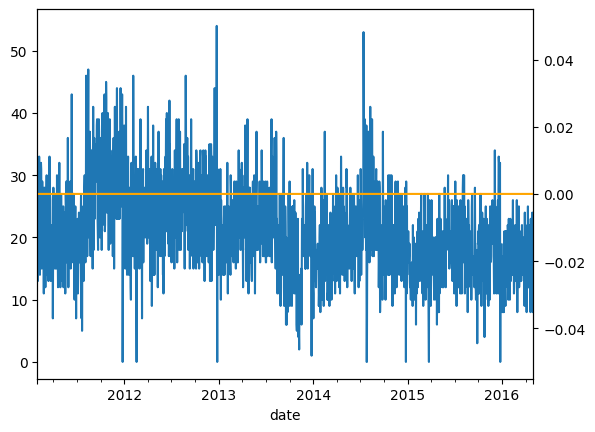

('FOODS_3_080', 'WI_1')


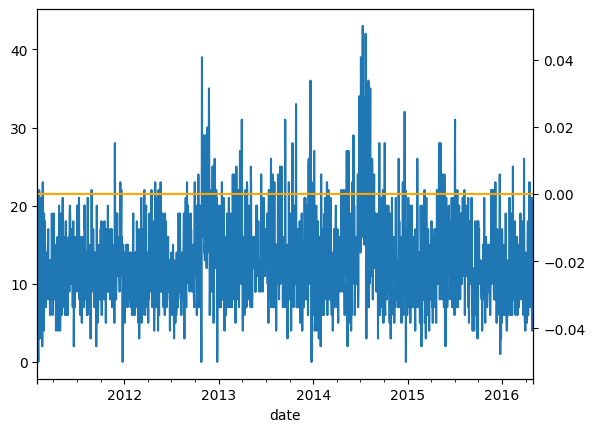

('FOODS_3_086', 'CA_3')


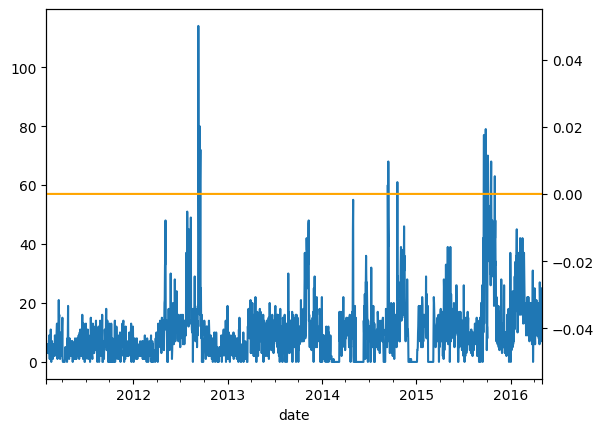

('FOODS_3_099', 'CA_1')


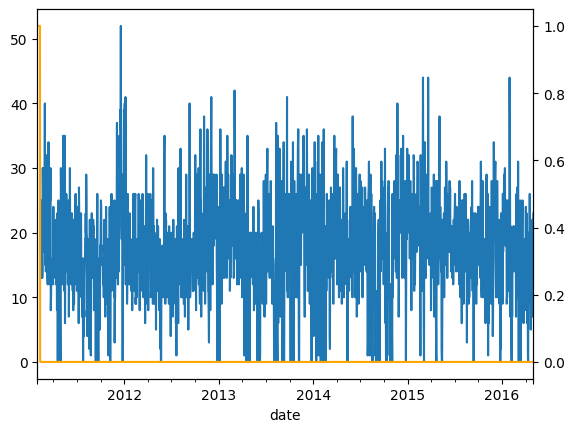

('FOODS_3_099', 'CA_2')


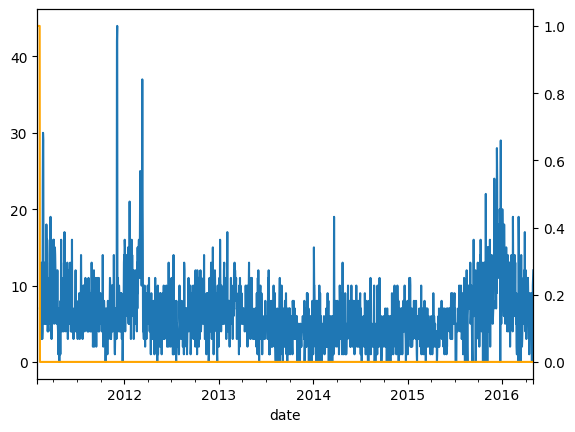

('FOODS_3_099', 'CA_3')


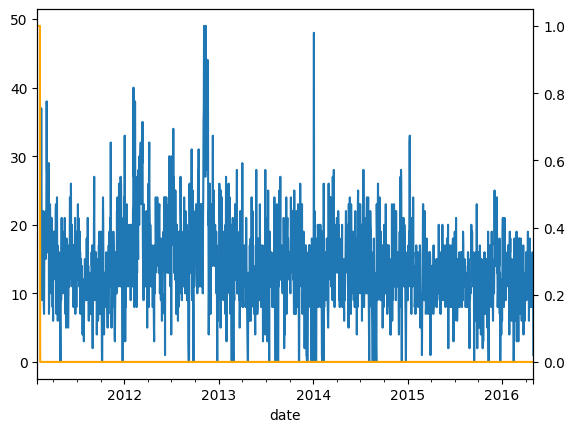

('FOODS_3_099', 'CA_4')


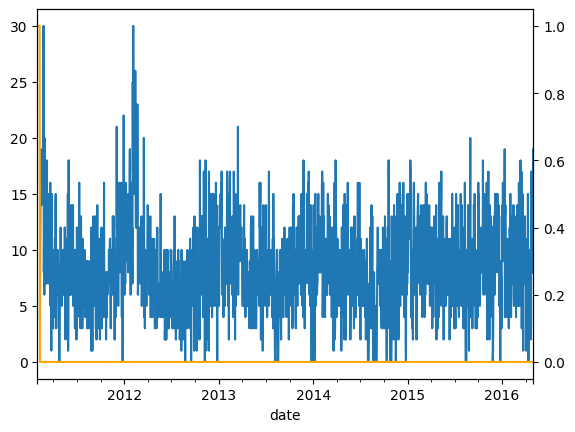

('FOODS_3_099', 'TX_1')


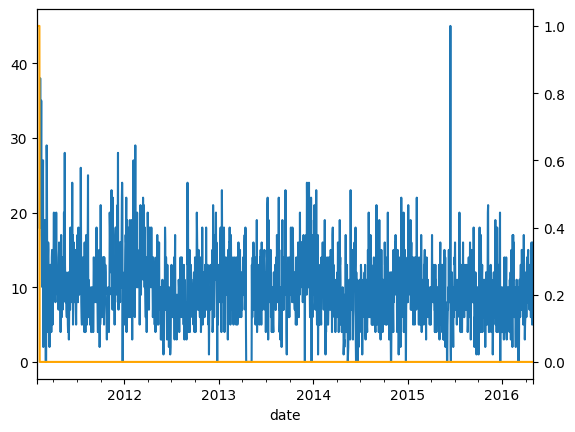

('FOODS_3_099', 'WI_1')


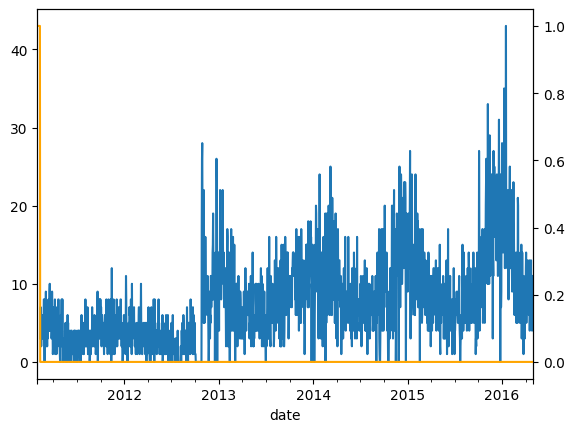

('FOODS_3_099', 'WI_2')


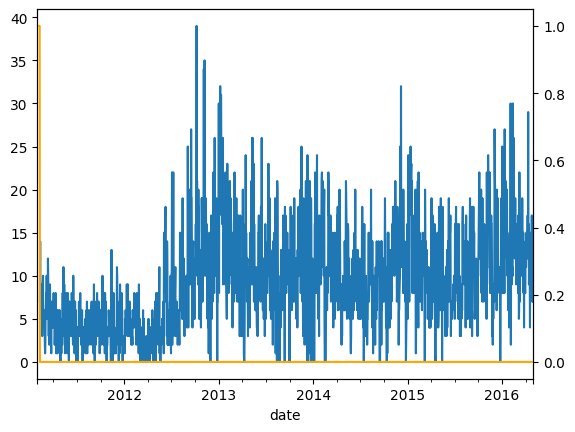

('FOODS_3_099', 'WI_3')


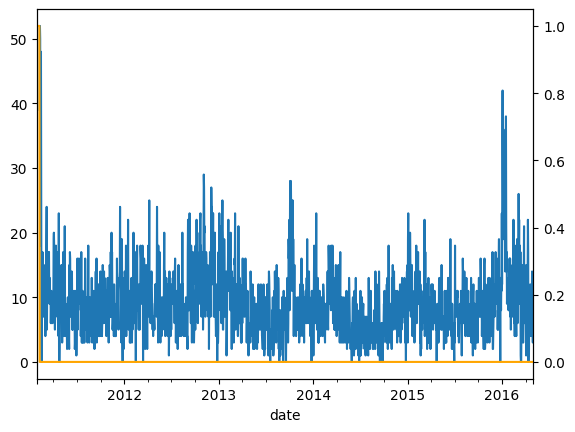

('FOODS_3_107', 'CA_3')


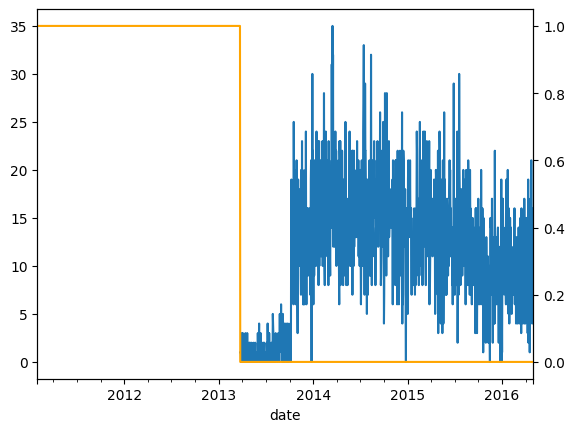

('FOODS_3_109', 'WI_3')


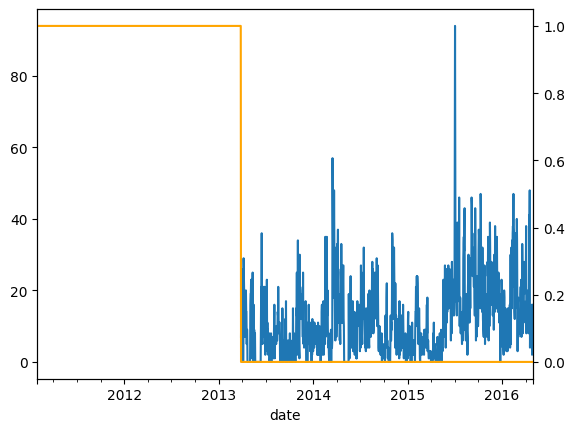

('FOODS_3_135', 'CA_3')


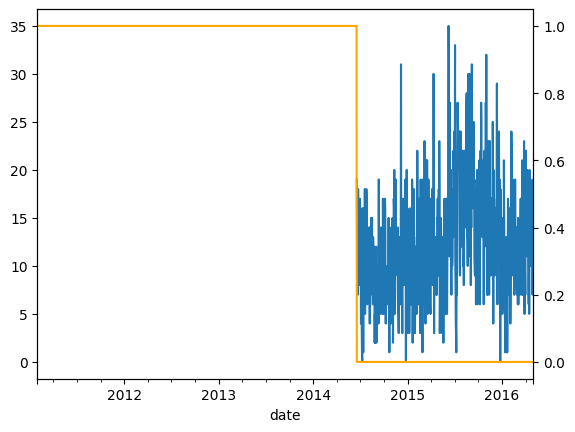

('FOODS_3_135', 'TX_2')


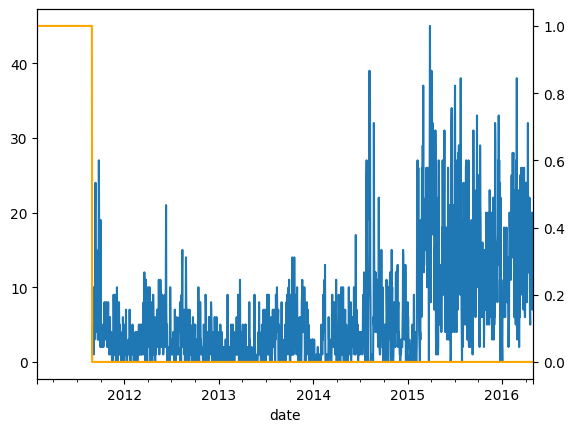

('FOODS_3_136', 'TX_1')


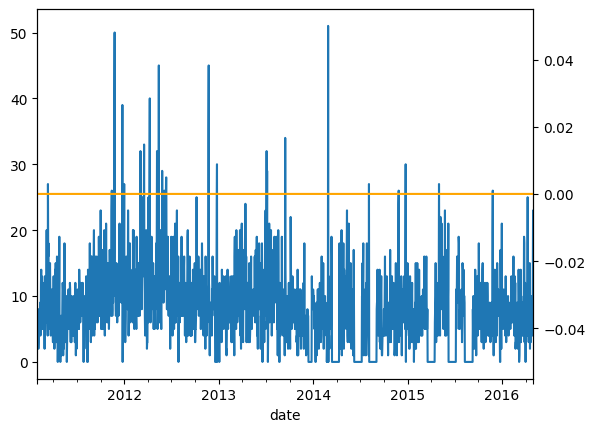

('FOODS_3_136', 'TX_2')


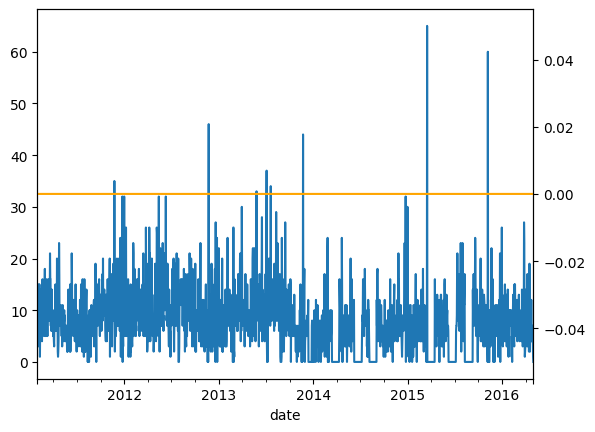

('FOODS_3_136', 'TX_3')


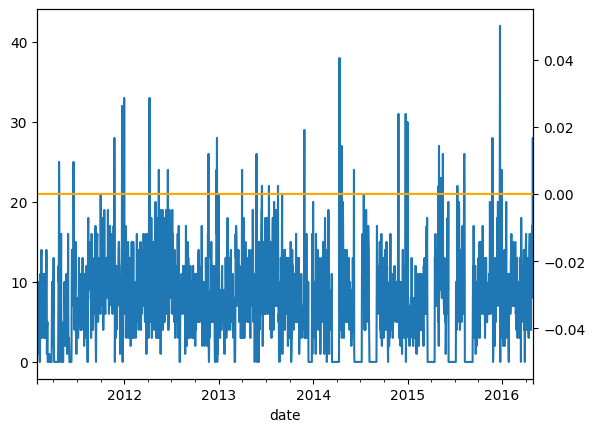

('FOODS_3_136', 'WI_2')


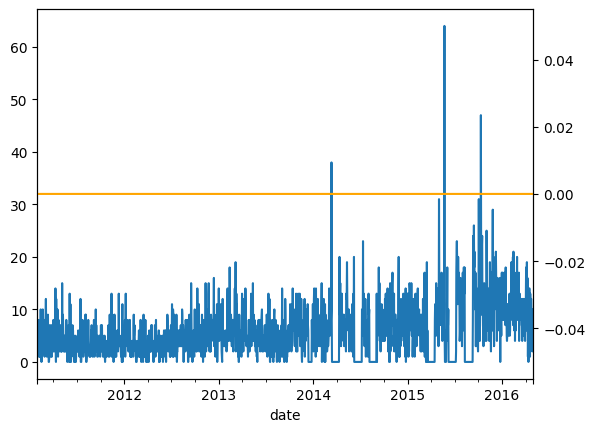

('FOODS_3_154', 'WI_3')


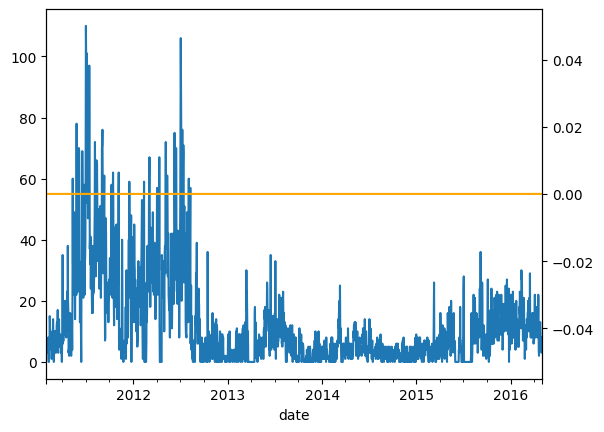

('FOODS_3_202', 'CA_1')


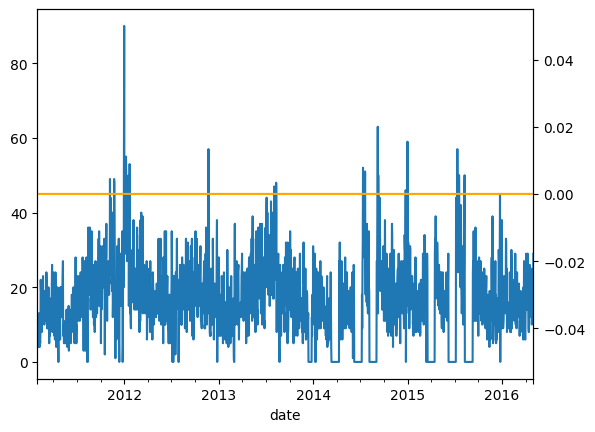

('FOODS_3_202', 'CA_2')


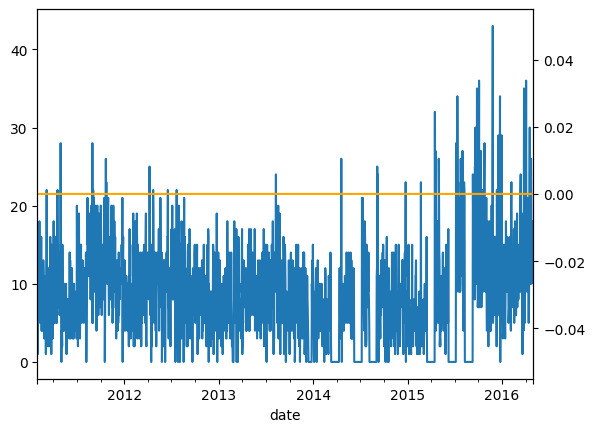

('FOODS_3_202', 'CA_3')


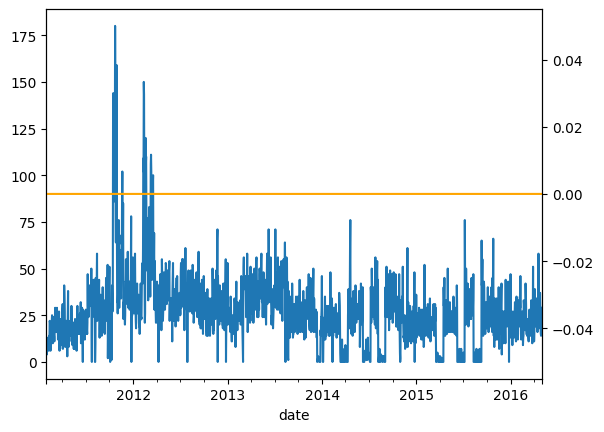

('FOODS_3_202', 'CA_4')


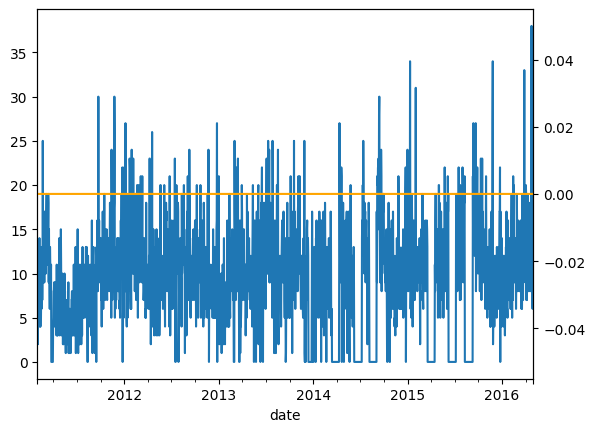

('FOODS_3_202', 'TX_1')


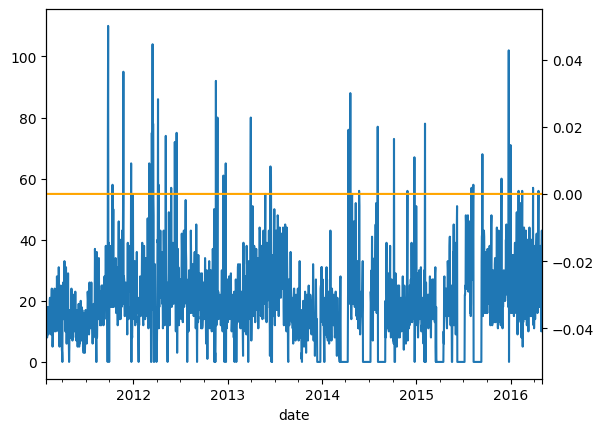

('FOODS_3_202', 'TX_2')


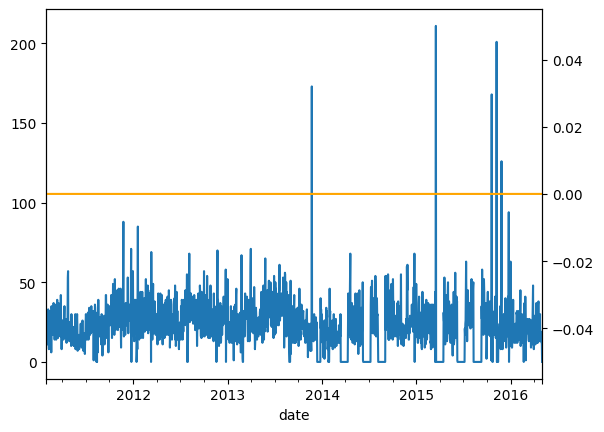

('FOODS_3_202', 'TX_3')


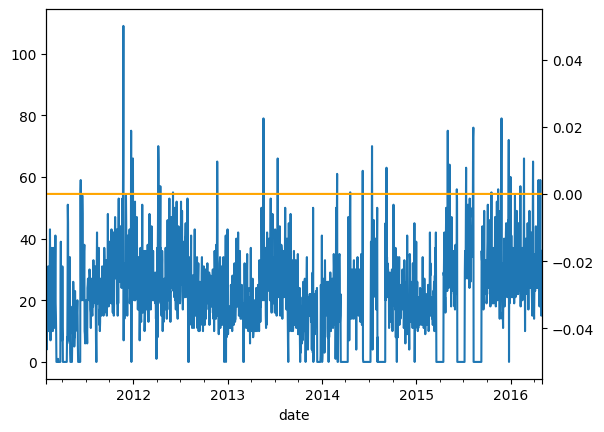

('FOODS_3_202', 'WI_1')


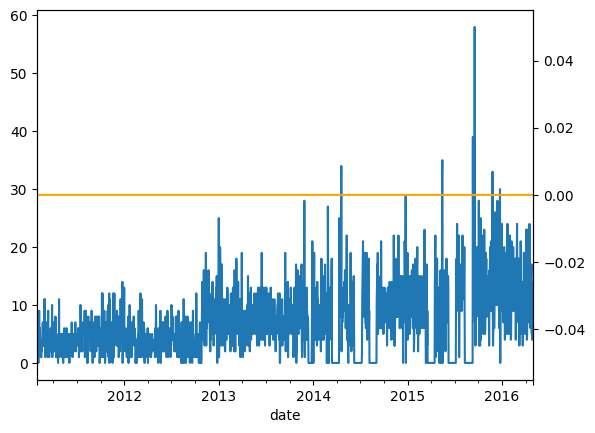

('FOODS_3_202', 'WI_2')


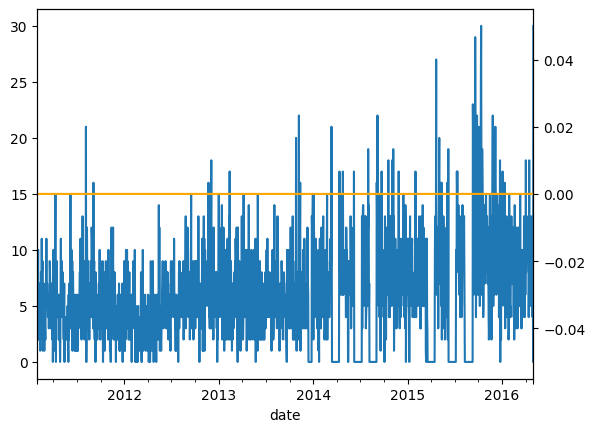

('FOODS_3_202', 'WI_3')


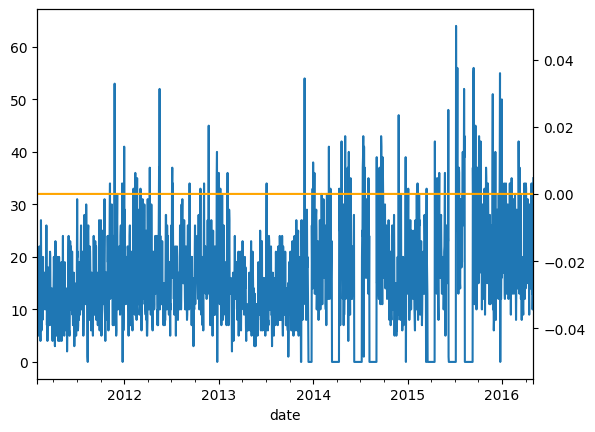

('FOODS_3_226', 'TX_1')


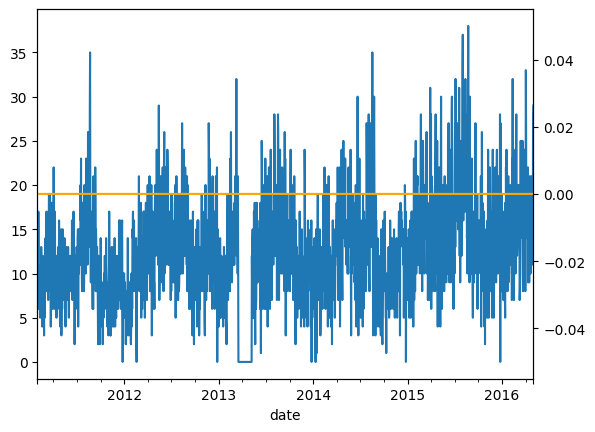

('FOODS_3_226', 'TX_2')


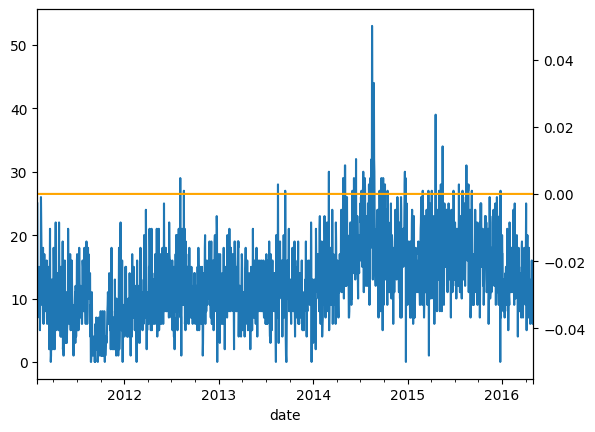

('FOODS_3_226', 'TX_3')


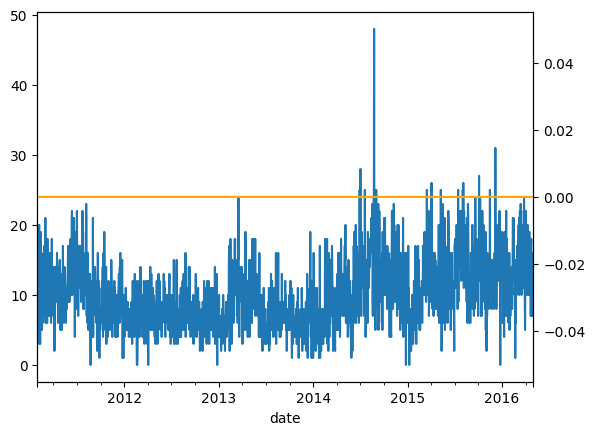

('FOODS_3_226', 'WI_1')


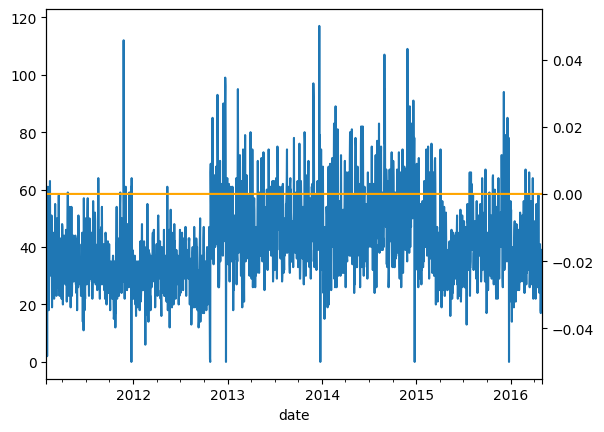

('FOODS_3_226', 'WI_2')


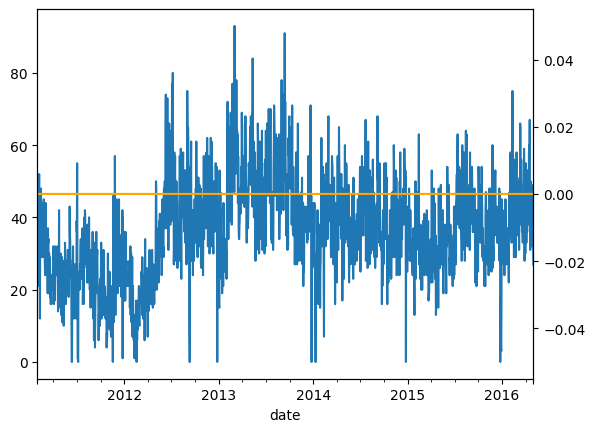

('FOODS_3_226', 'WI_3')


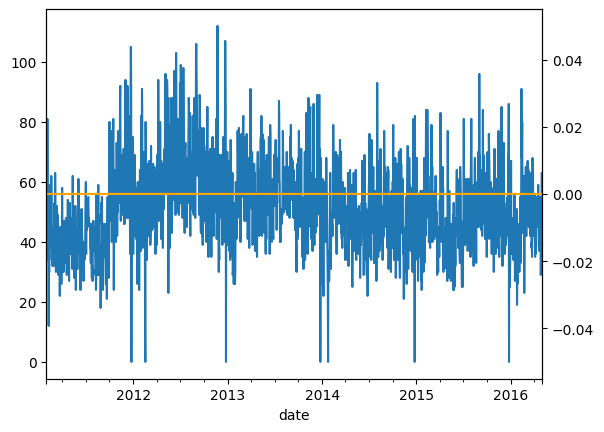

('FOODS_3_227', 'TX_2')


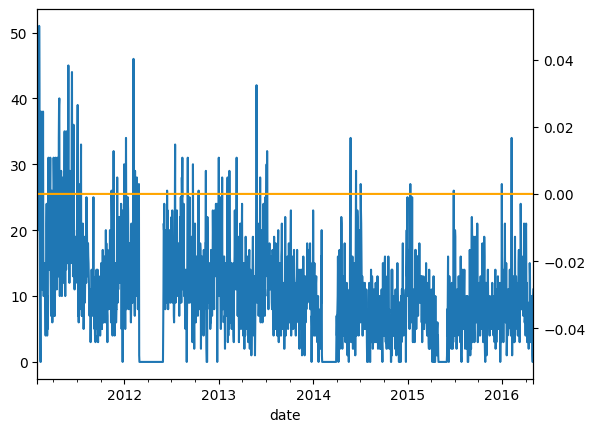

('FOODS_3_227', 'TX_3')


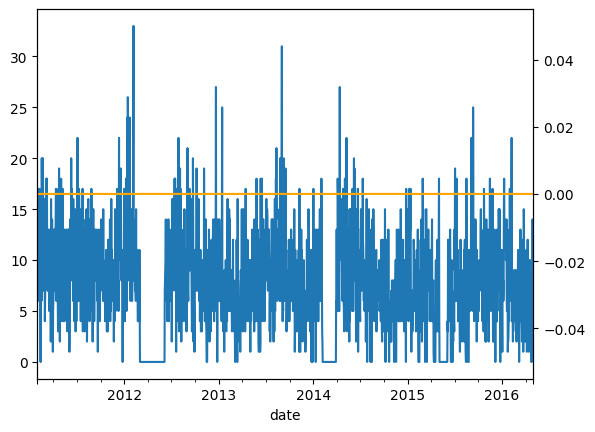

('FOODS_3_228', 'TX_2')


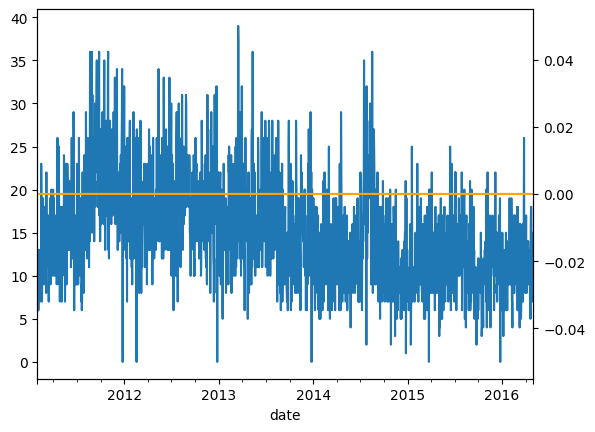

('FOODS_3_252', 'CA_1')


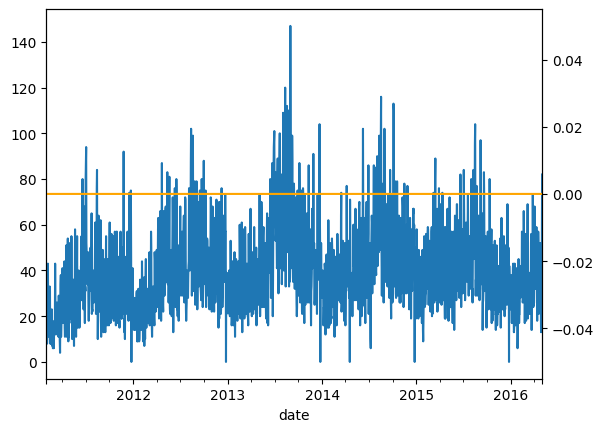

('FOODS_3_252', 'CA_2')


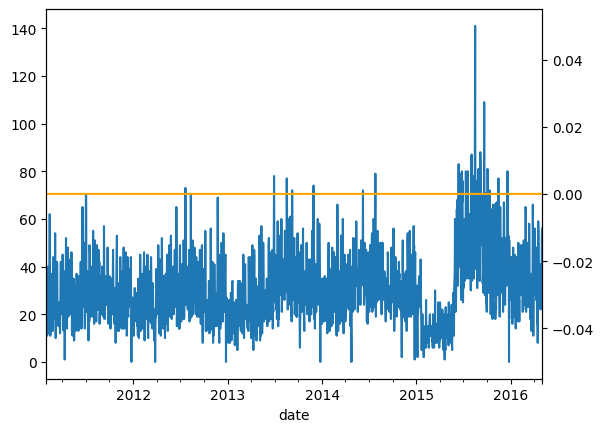

('FOODS_3_252', 'CA_3')


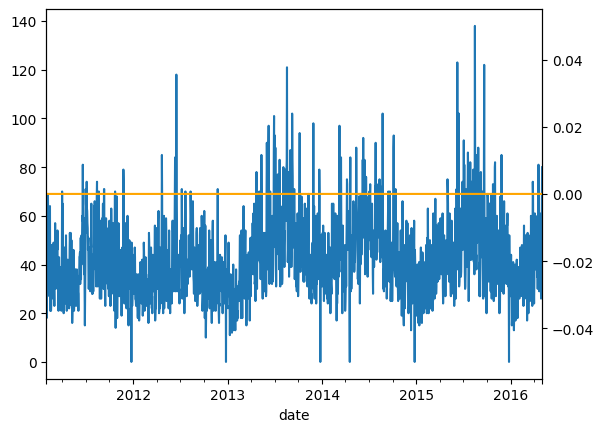

('FOODS_3_252', 'TX_1')


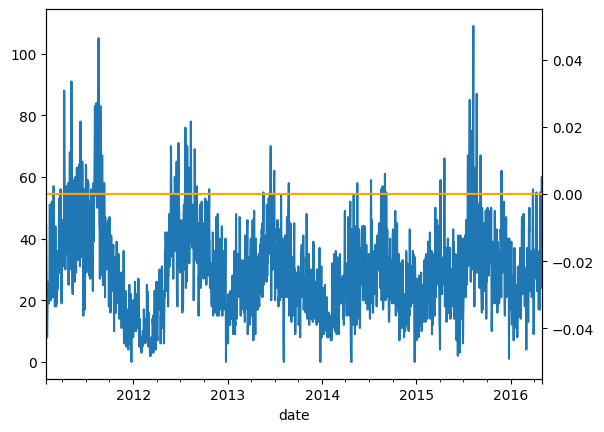

('FOODS_3_252', 'TX_2')


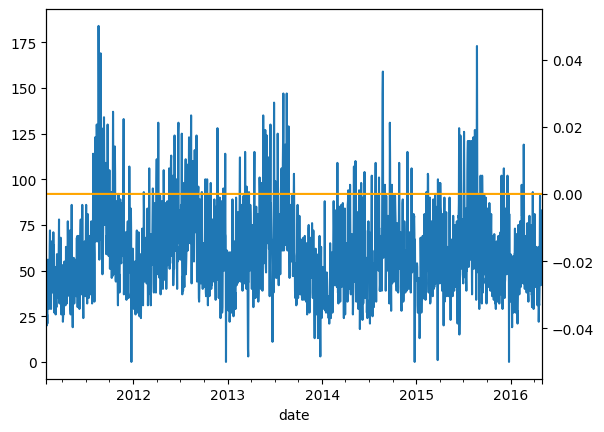

('FOODS_3_252', 'TX_3')


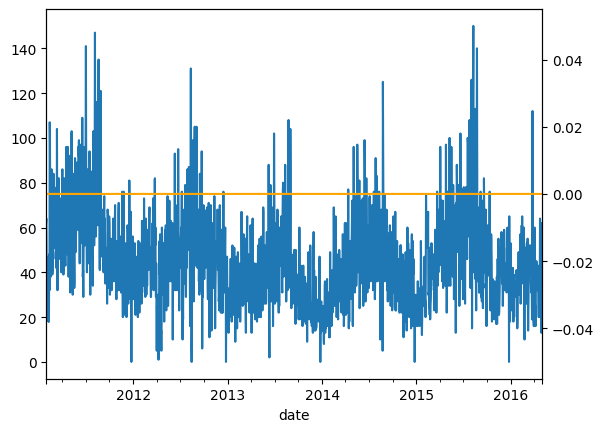

('FOODS_3_252', 'WI_3')


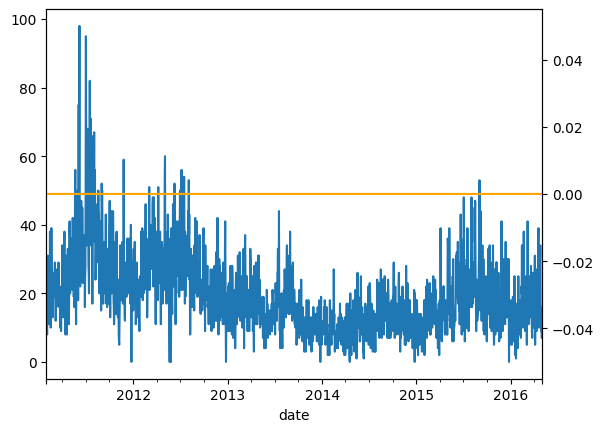

('FOODS_3_282', 'CA_3')


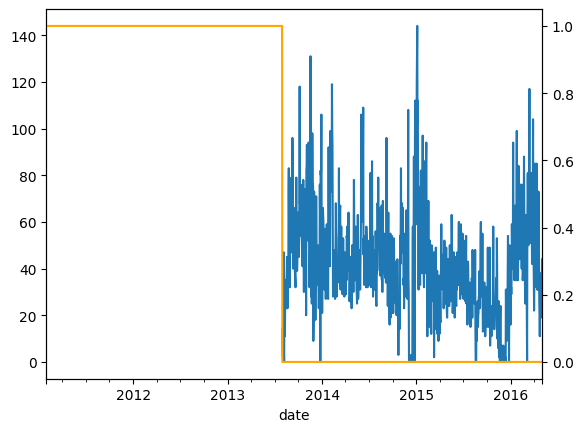

('FOODS_3_288', 'CA_1')


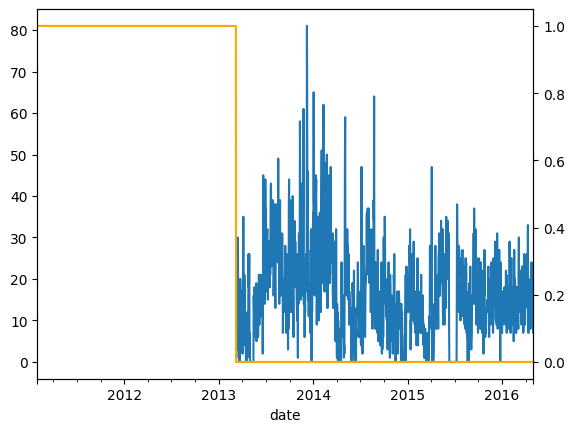

('FOODS_3_288', 'CA_2')


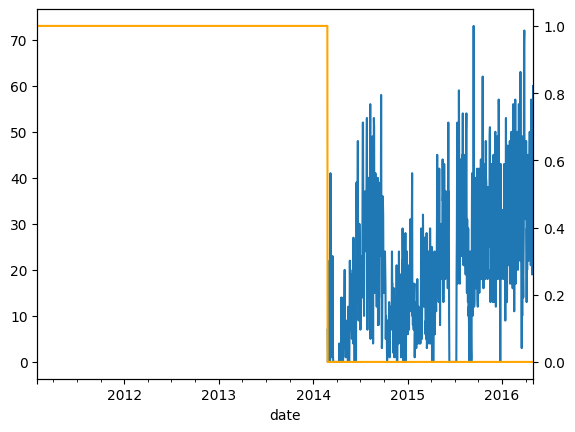

('FOODS_3_288', 'CA_3')


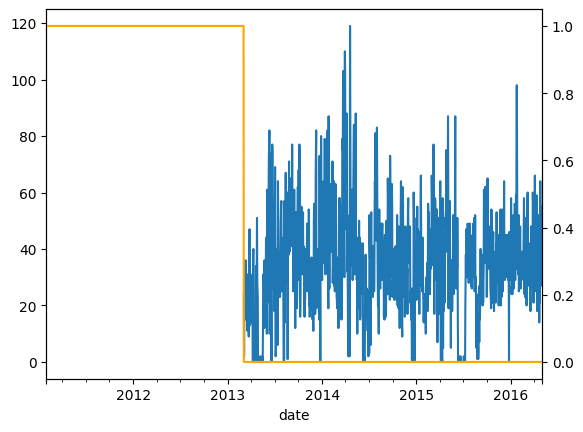

('FOODS_3_313', 'CA_3')


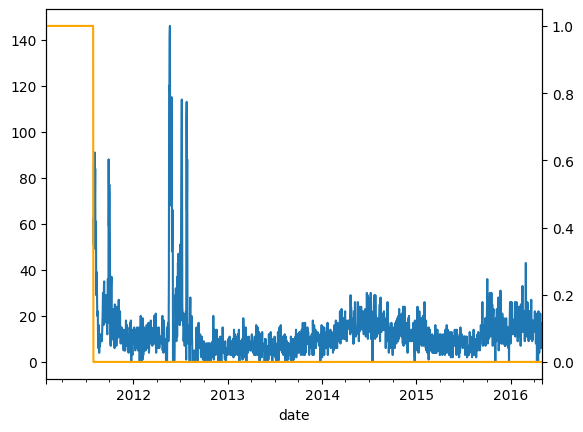

('FOODS_3_372', 'CA_3')


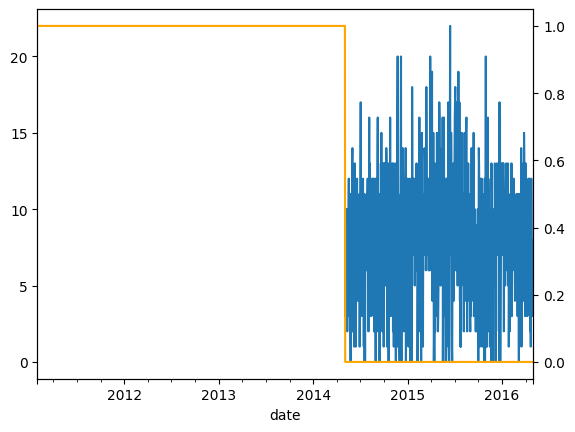

('FOODS_3_376', 'WI_2')


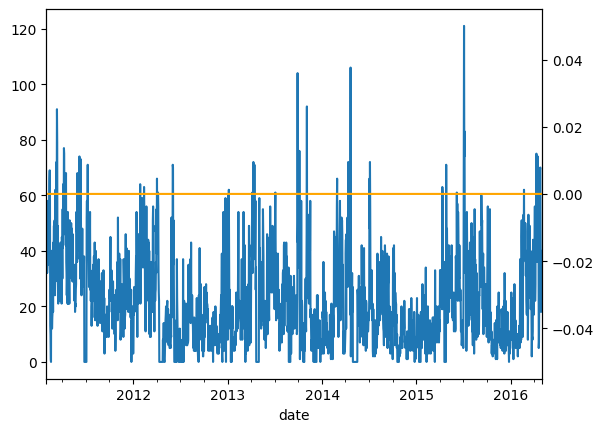

('FOODS_3_376', 'WI_3')


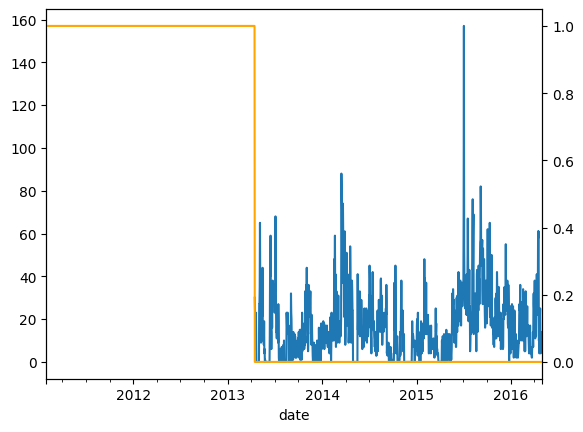

('FOODS_3_377', 'TX_1')


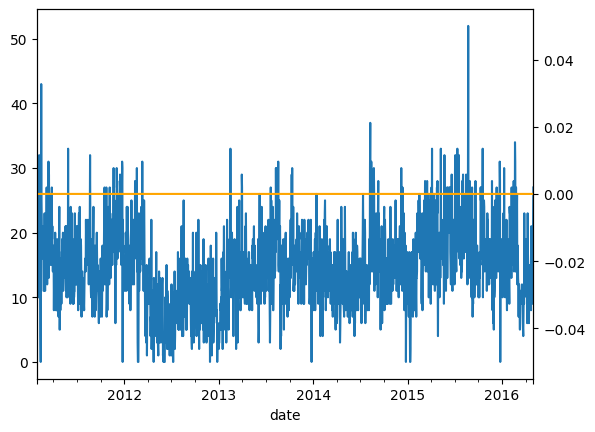

('FOODS_3_377', 'TX_2')


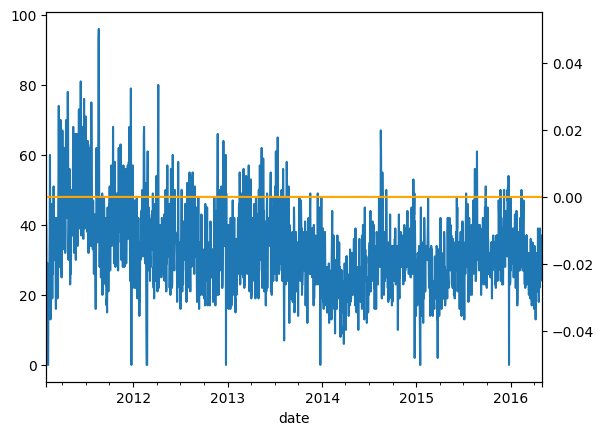

('FOODS_3_377', 'TX_3')


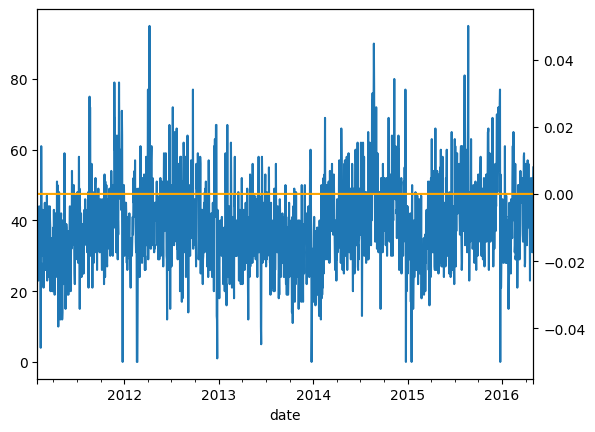

('FOODS_3_389', 'CA_2')


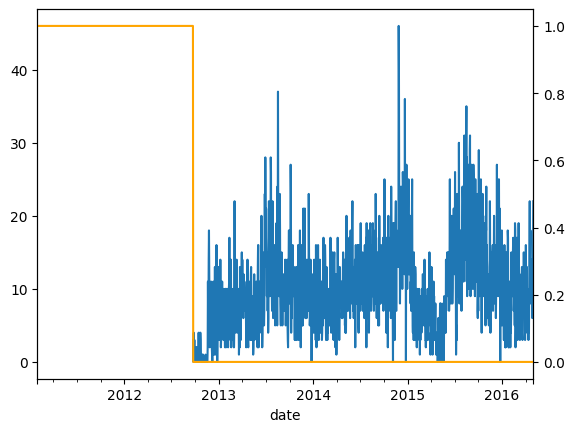

('FOODS_3_389', 'CA_3')


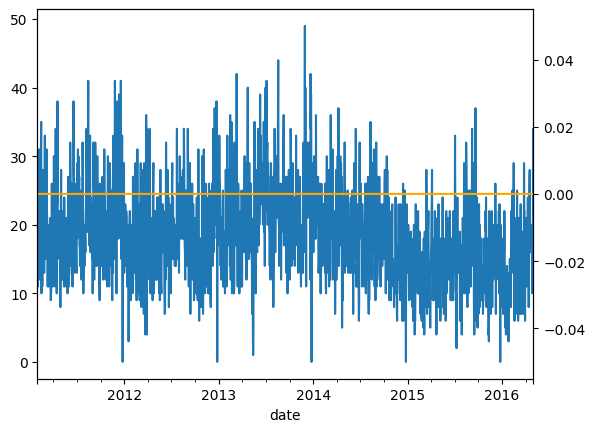

('FOODS_3_389', 'TX_1')


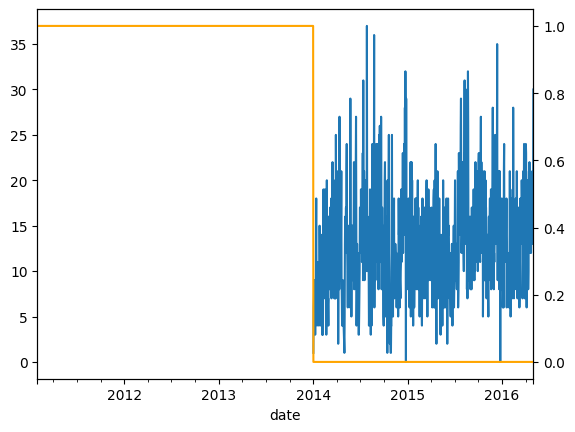

('FOODS_3_389', 'TX_2')


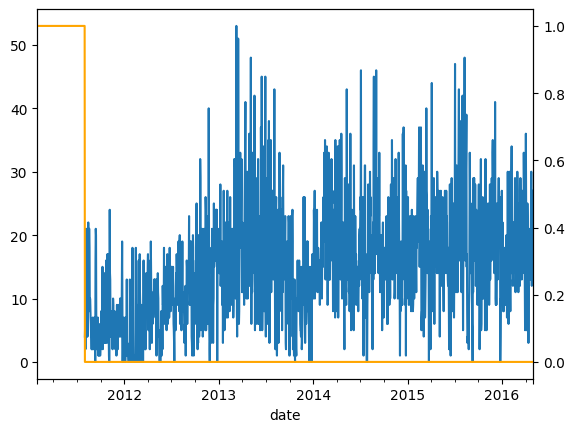

('FOODS_3_389', 'TX_3')


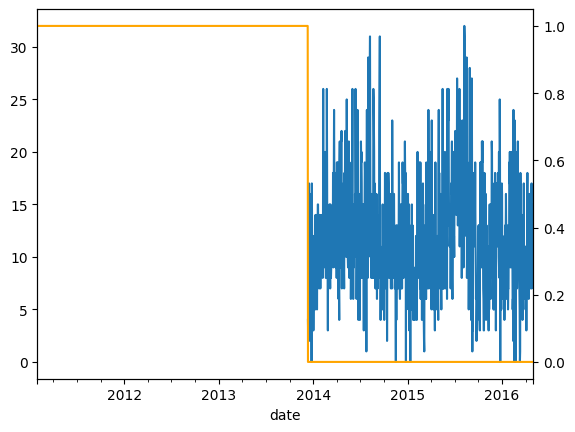

('FOODS_3_403', 'CA_3')


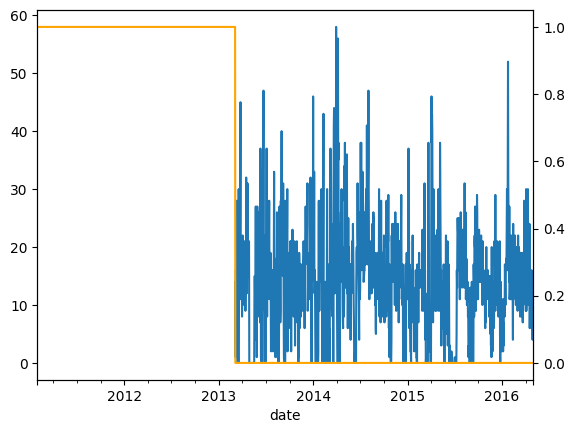

('FOODS_3_455', 'CA_1')


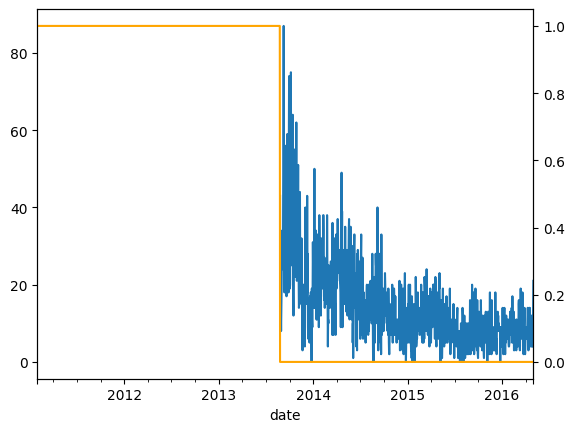

('FOODS_3_455', 'CA_3')


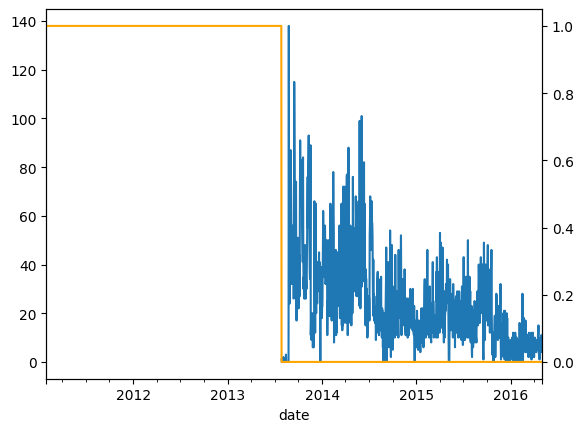

('FOODS_3_455', 'TX_1')


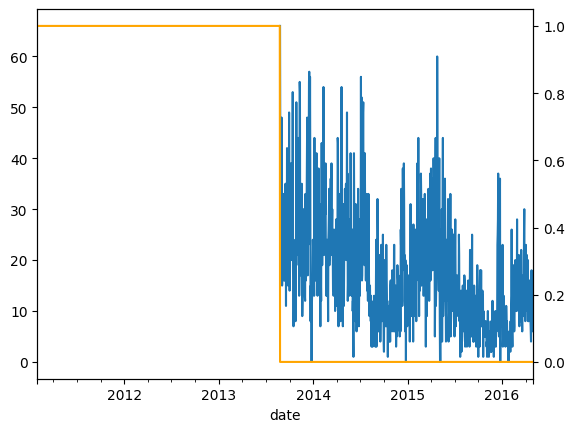

('FOODS_3_455', 'TX_2')


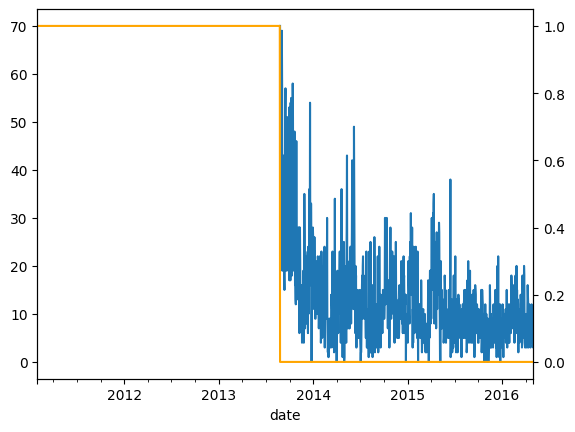

('FOODS_3_455', 'TX_3')


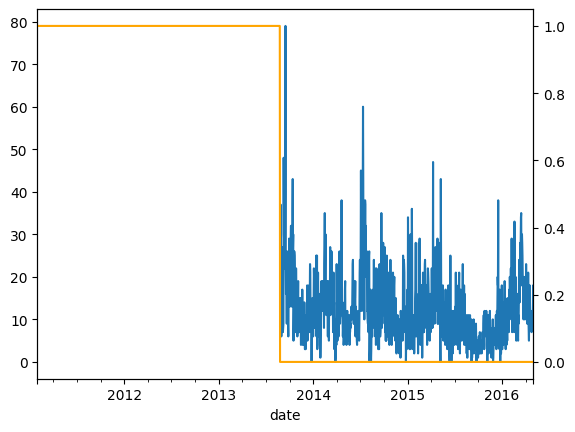

('FOODS_3_458', 'CA_3')


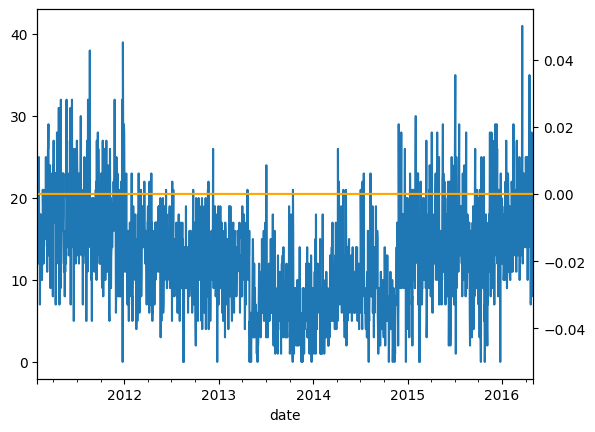

('FOODS_3_458', 'TX_2')


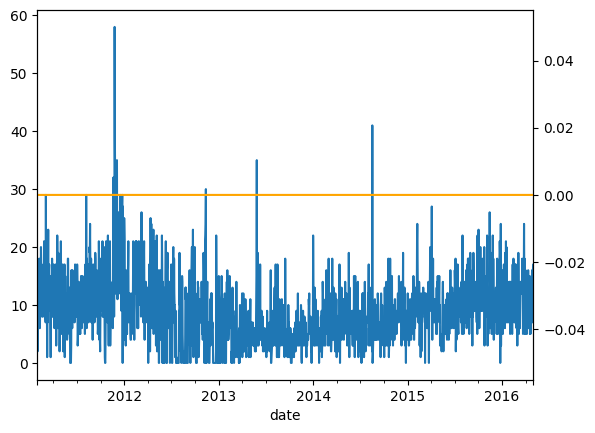

('FOODS_3_458', 'WI_2')


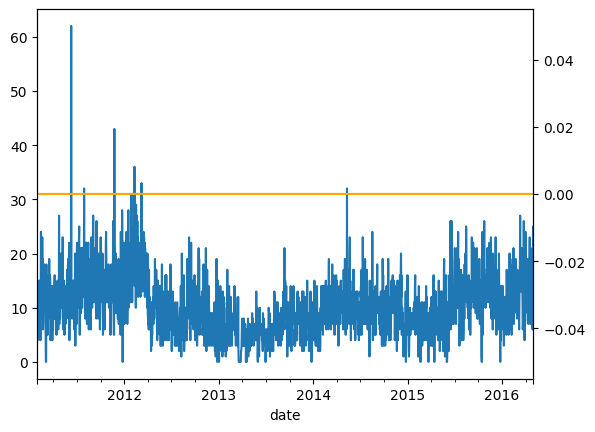

('FOODS_3_458', 'WI_3')


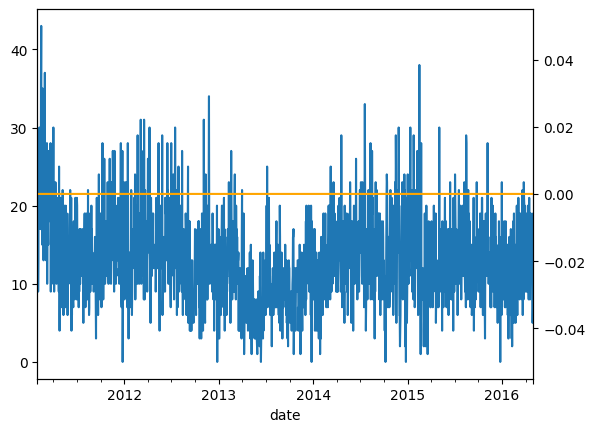

('FOODS_3_473', 'CA_1')


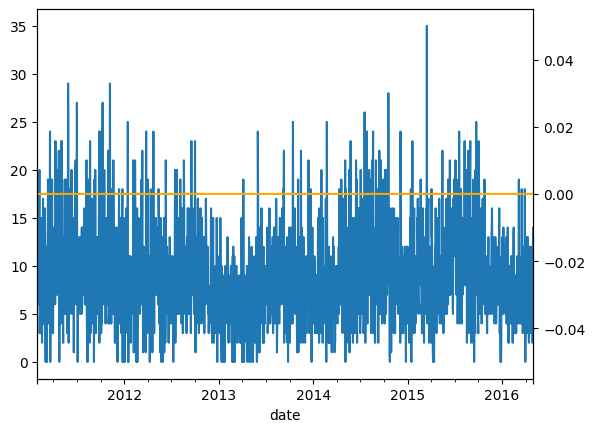

('FOODS_3_499', 'CA_1')


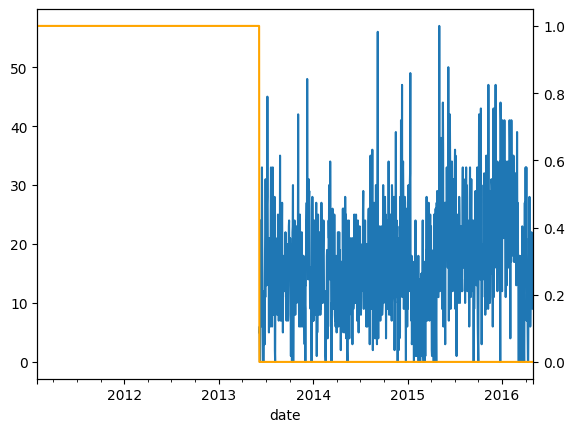

('FOODS_3_499', 'CA_2')


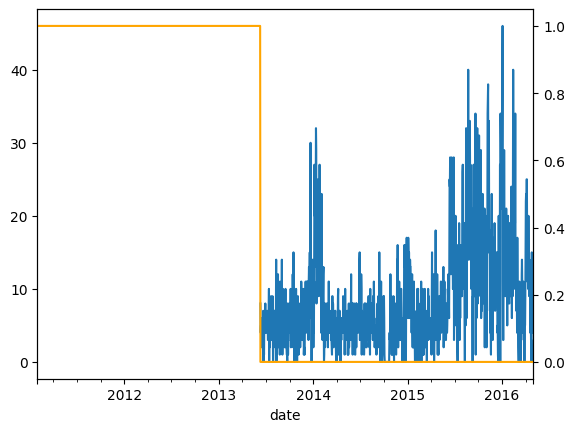

('FOODS_3_499', 'CA_3')


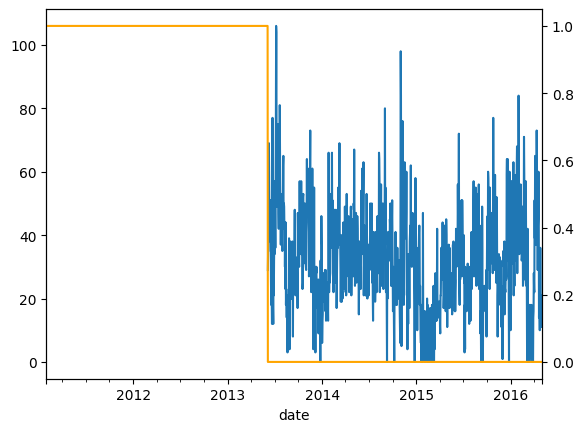

('FOODS_3_499', 'TX_1')


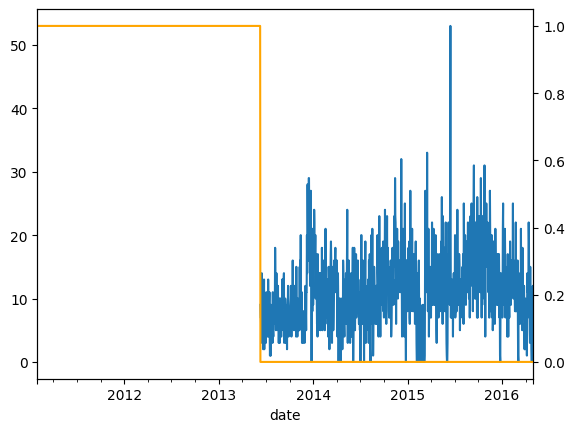

('FOODS_3_499', 'TX_2')


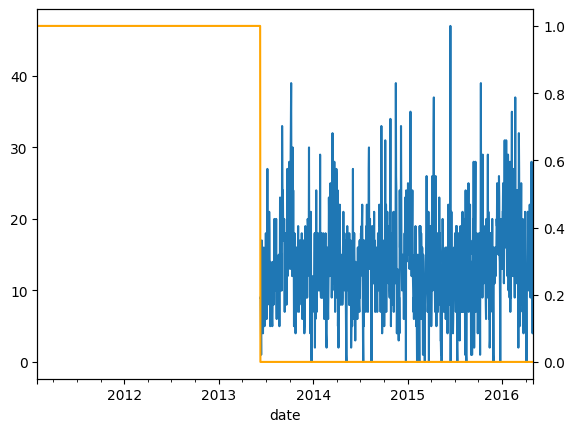

('FOODS_3_499', 'TX_3')


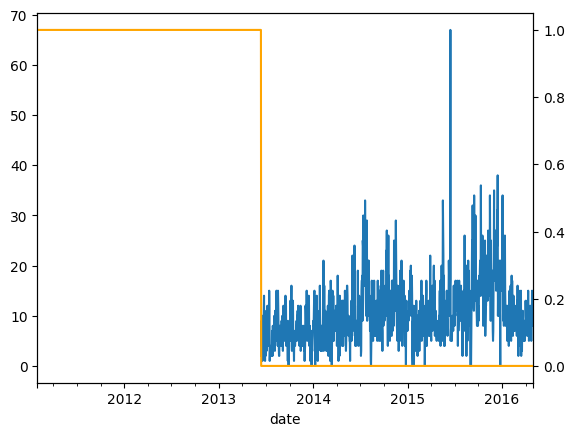

('FOODS_3_499', 'WI_3')


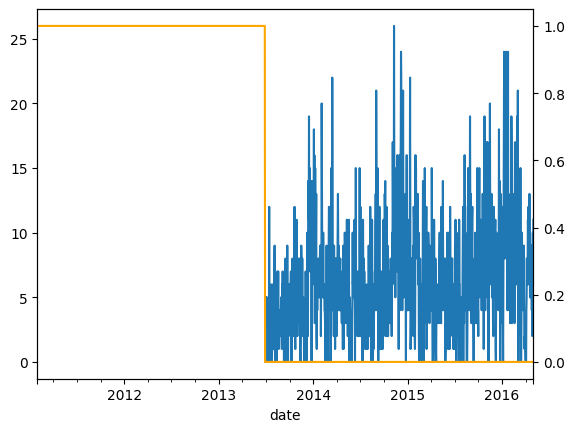

('FOODS_3_503', 'CA_3')


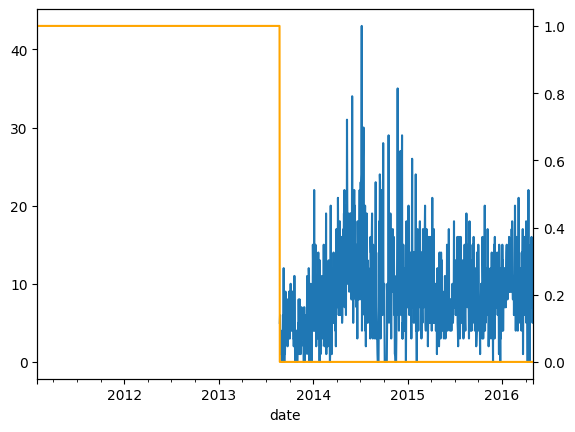

('FOODS_3_503', 'TX_2')


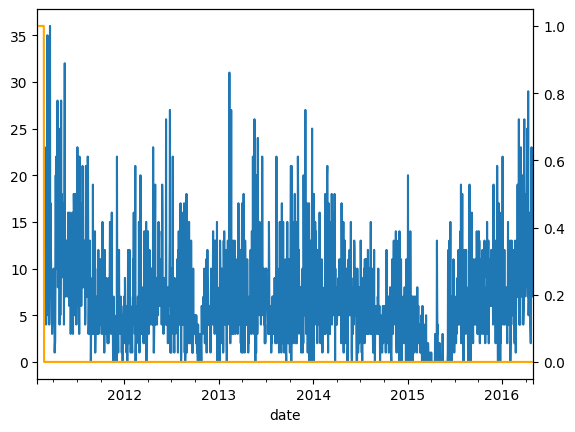

('FOODS_3_516', 'CA_1')


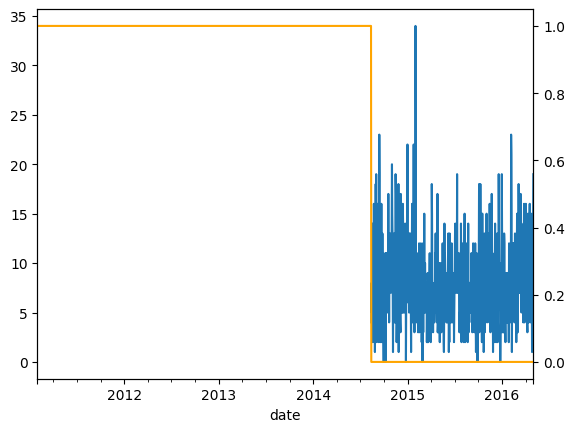

('FOODS_3_516', 'CA_2')


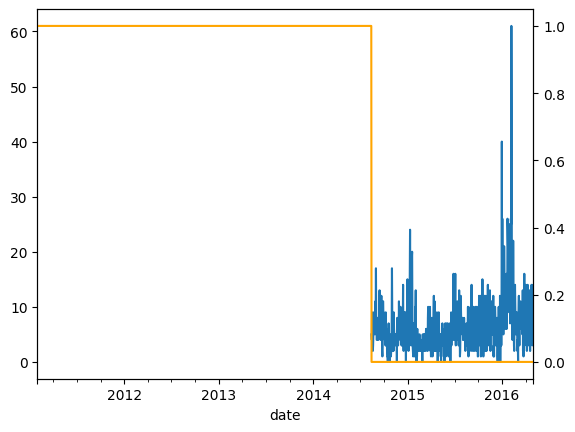

('FOODS_3_516', 'CA_3')


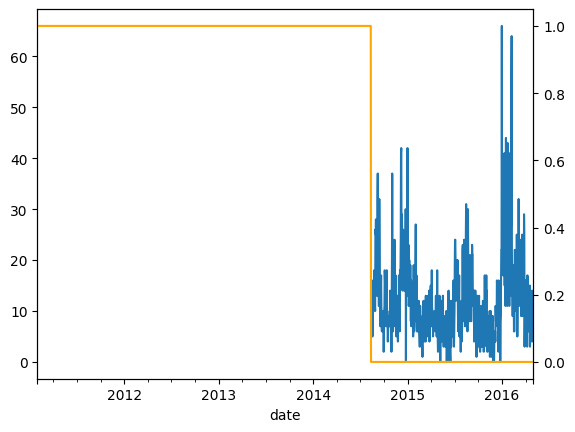

('FOODS_3_516', 'TX_1')


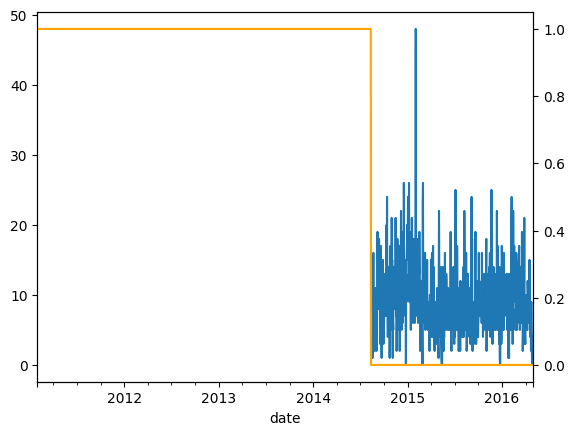

('FOODS_3_516', 'TX_2')


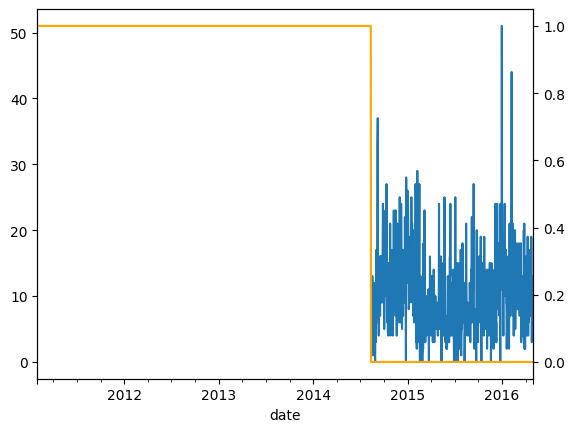

('FOODS_3_516', 'TX_3')


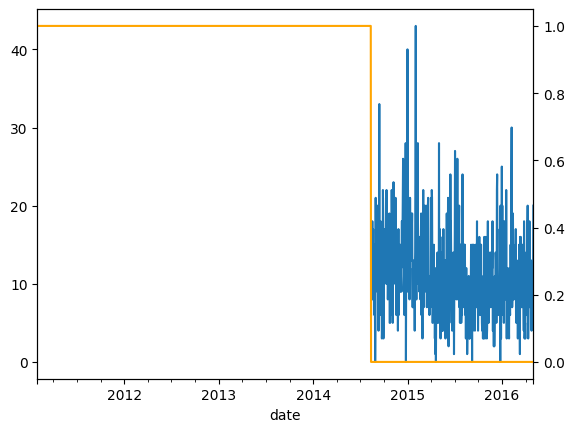

('FOODS_3_516', 'WI_1')


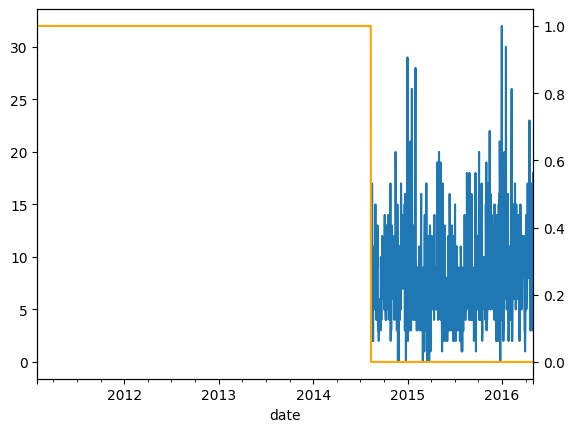

('FOODS_3_516', 'WI_2')


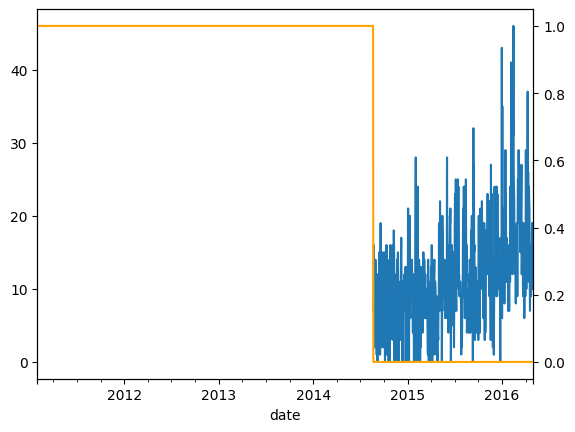

('FOODS_3_516', 'WI_3')


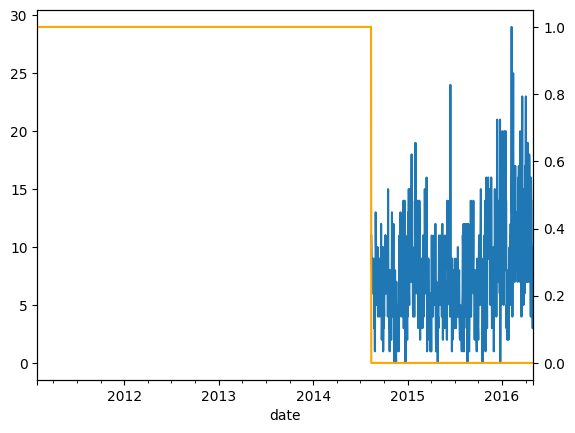

('FOODS_3_555', 'CA_1')


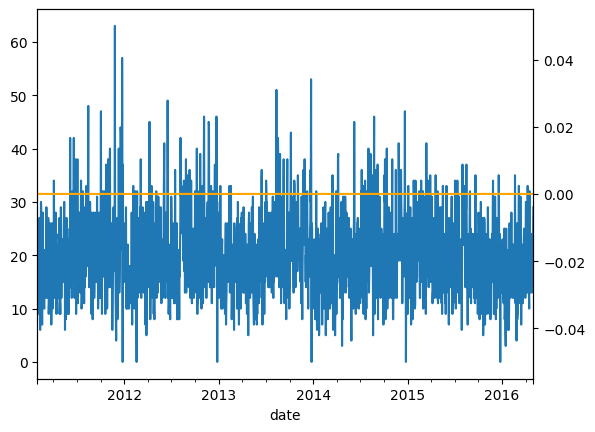

('FOODS_3_555', 'CA_2')


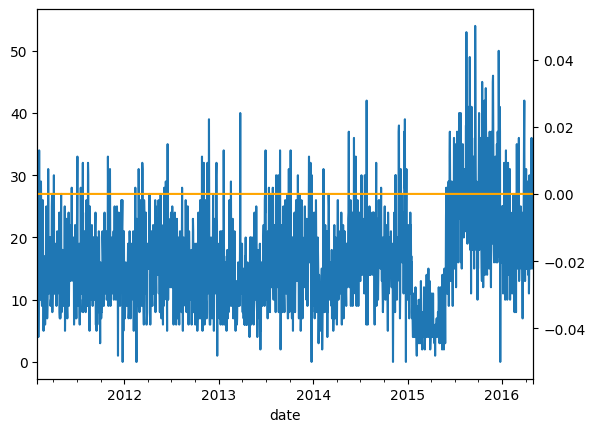

('FOODS_3_555', 'CA_3')


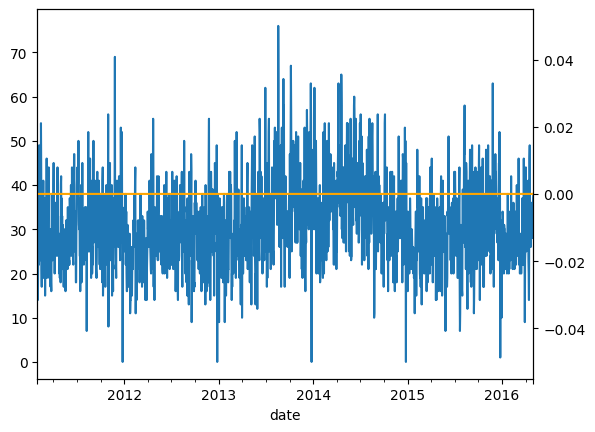

('FOODS_3_555', 'TX_1')


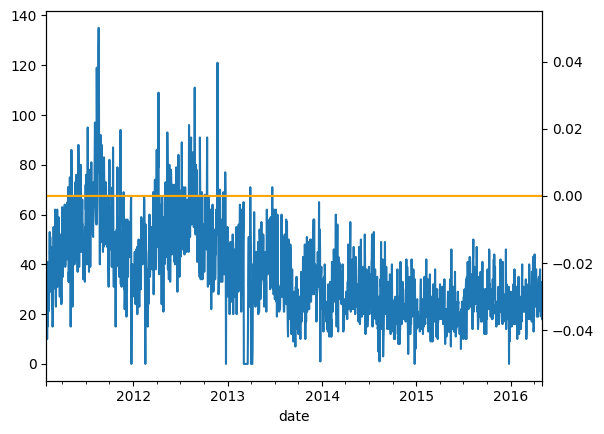

('FOODS_3_555', 'TX_2')


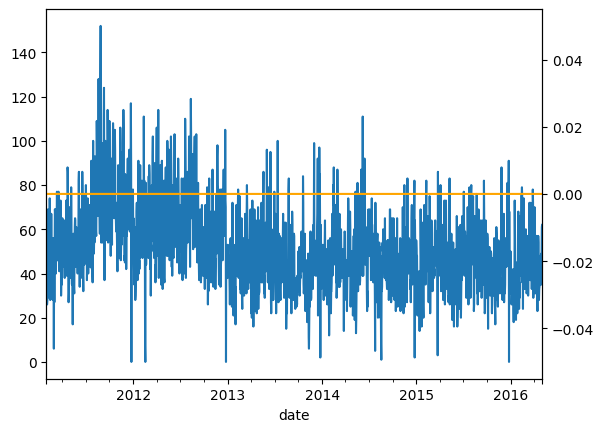

('FOODS_3_555', 'TX_3')


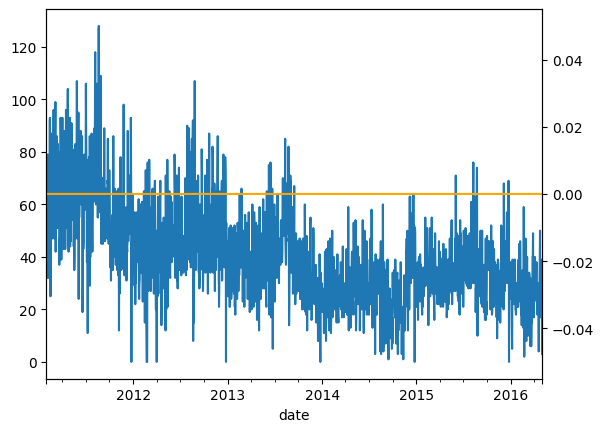

('FOODS_3_555', 'WI_2')


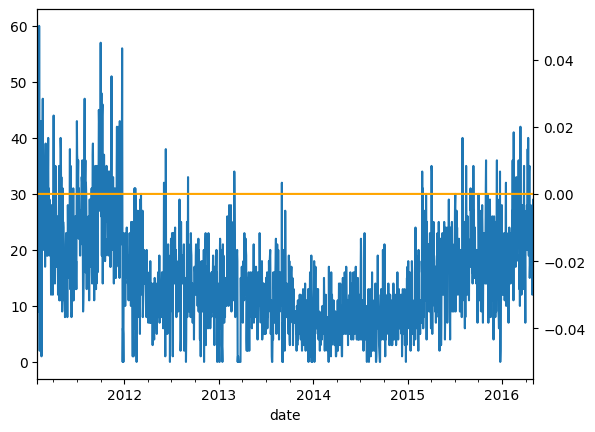

('FOODS_3_555', 'WI_3')


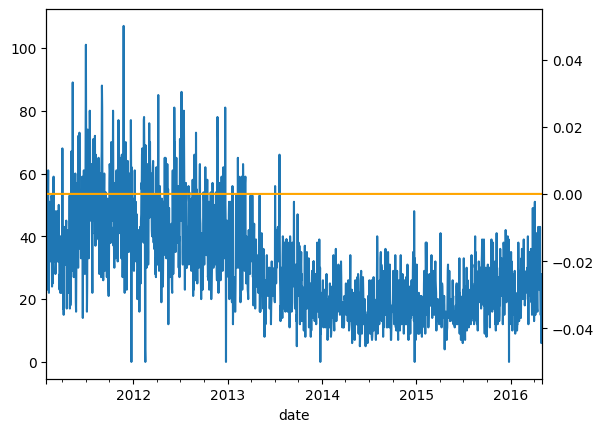

('FOODS_3_586', 'CA_1')


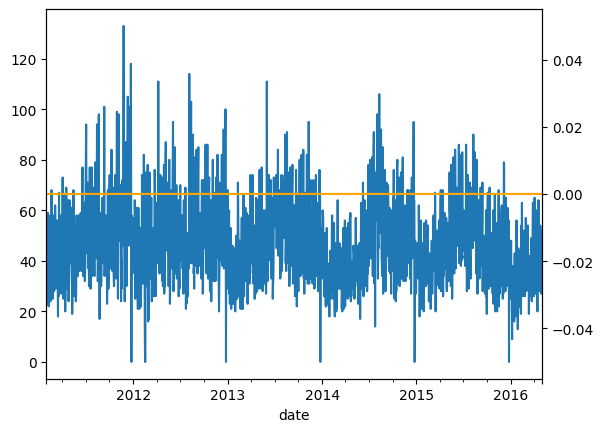

('FOODS_3_586', 'CA_2')


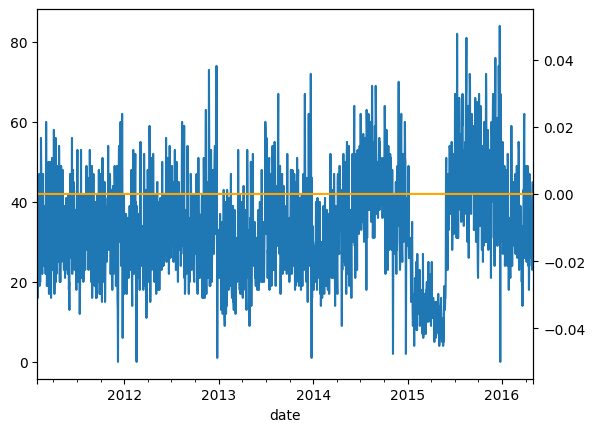

('FOODS_3_586', 'CA_3')


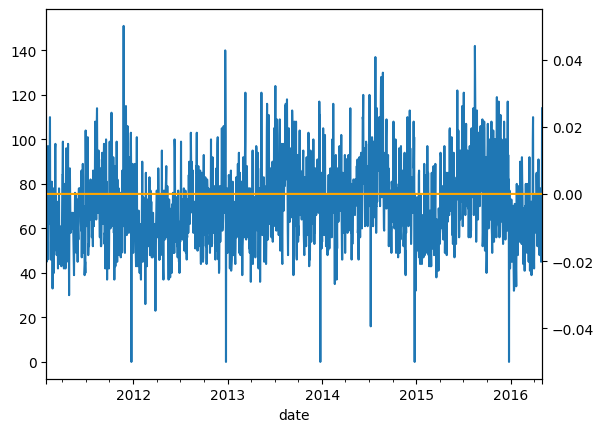

('FOODS_3_586', 'CA_4')


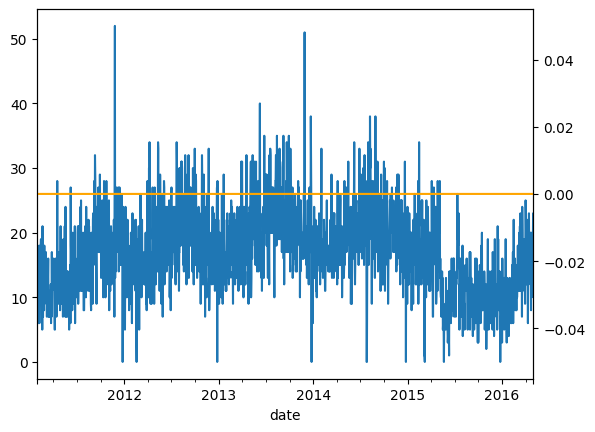

('FOODS_3_586', 'TX_1')


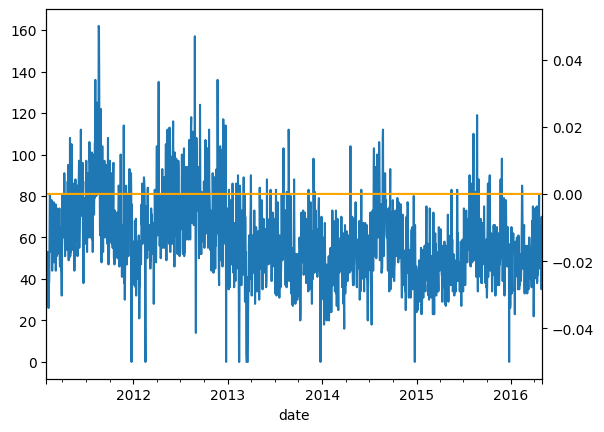

('FOODS_3_586', 'TX_2')


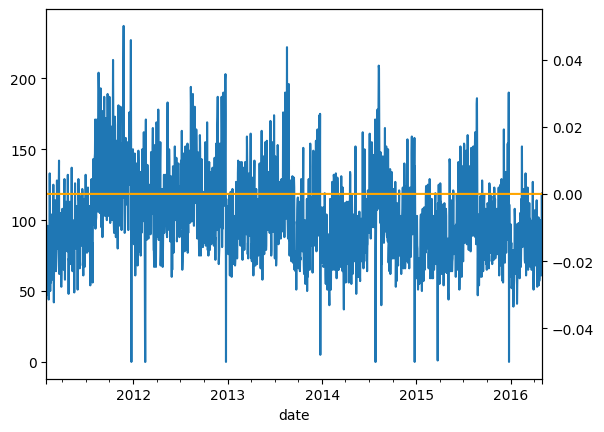

('FOODS_3_586', 'TX_3')


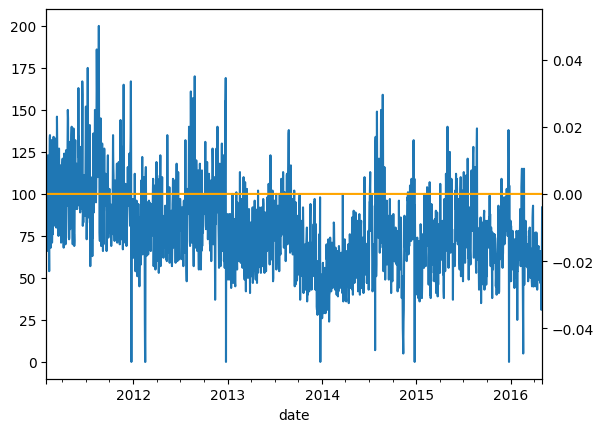

('FOODS_3_586', 'WI_1')


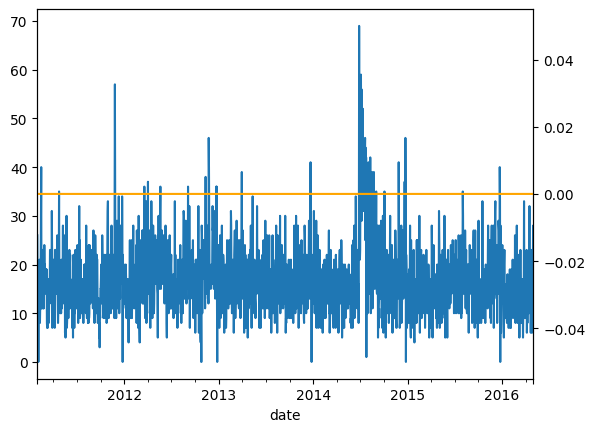

('FOODS_3_586', 'WI_2')


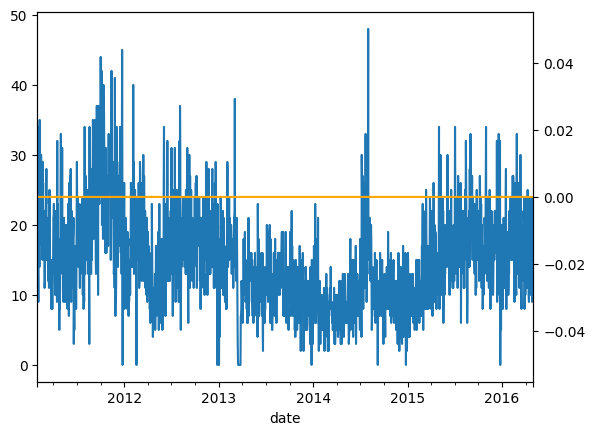

('FOODS_3_586', 'WI_3')


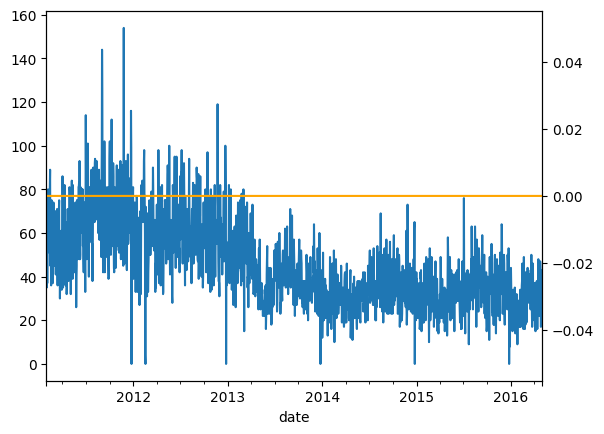

('FOODS_3_587', 'CA_1')


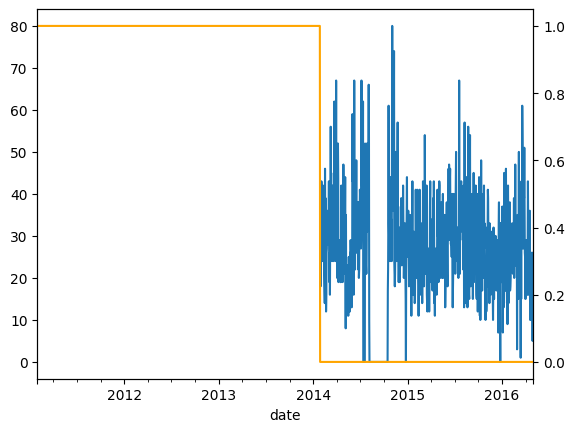

('FOODS_3_587', 'CA_2')


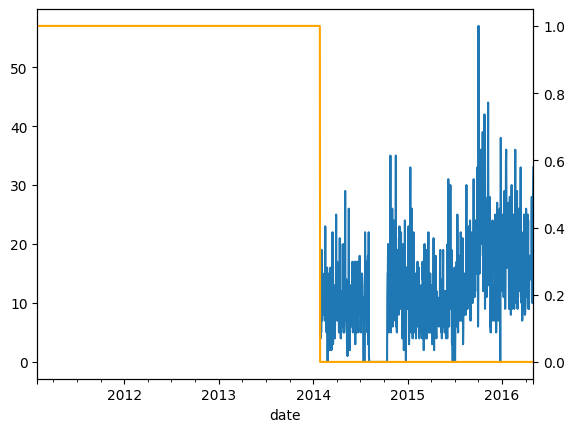

('FOODS_3_587', 'CA_3')


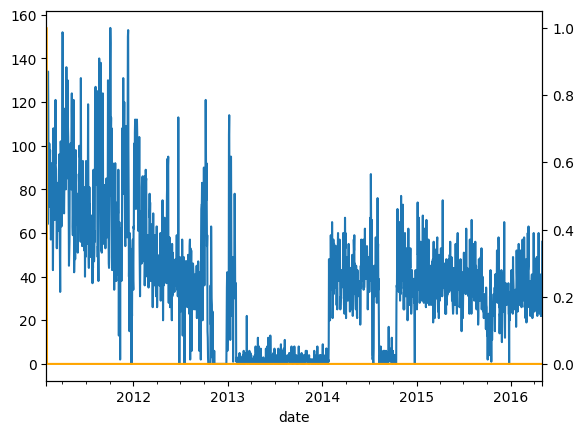

('FOODS_3_587', 'CA_4')


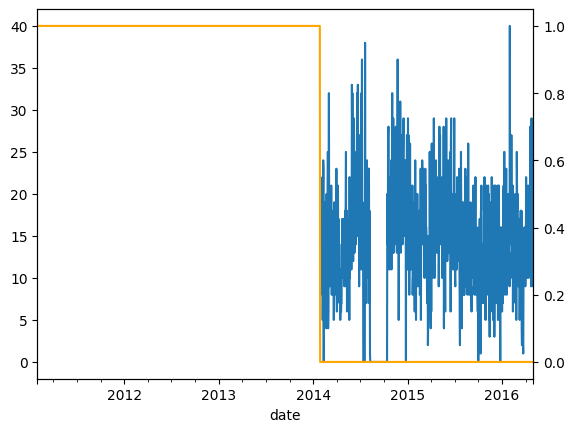

('FOODS_3_587', 'TX_2')


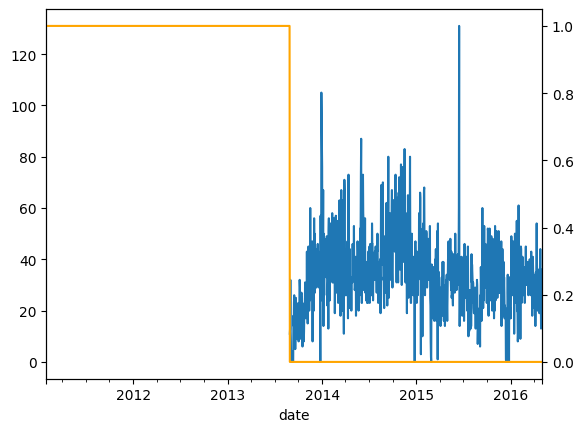

('FOODS_3_587', 'TX_3')


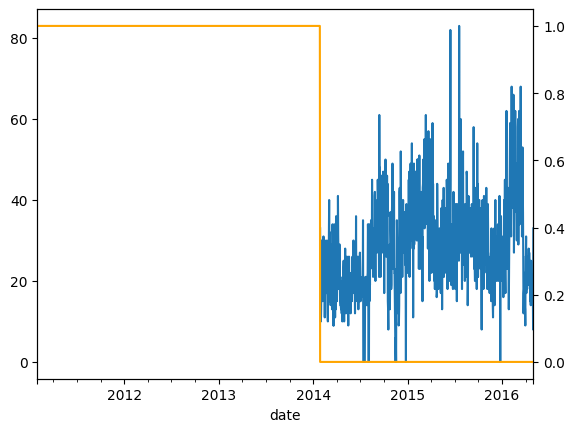

('FOODS_3_607', 'CA_1')


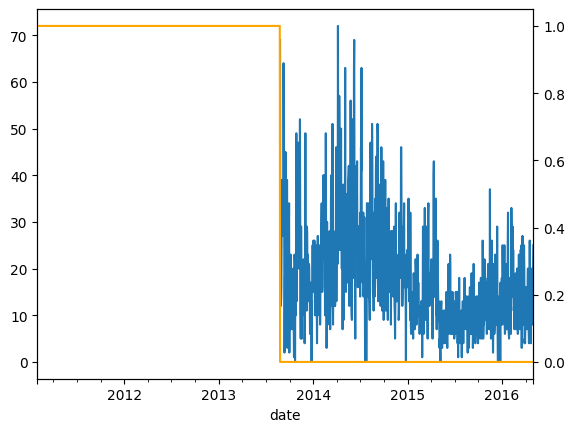

('FOODS_3_607', 'CA_2')


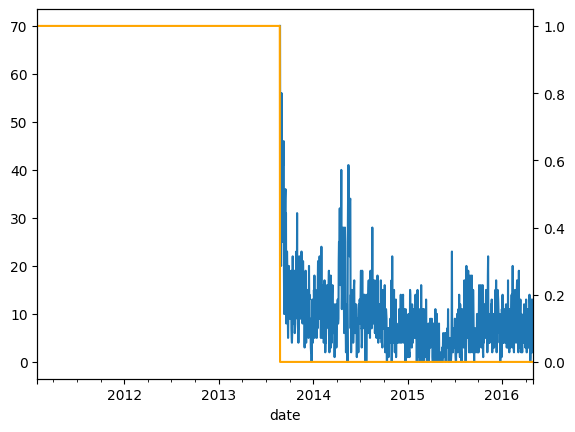

('FOODS_3_607', 'CA_3')


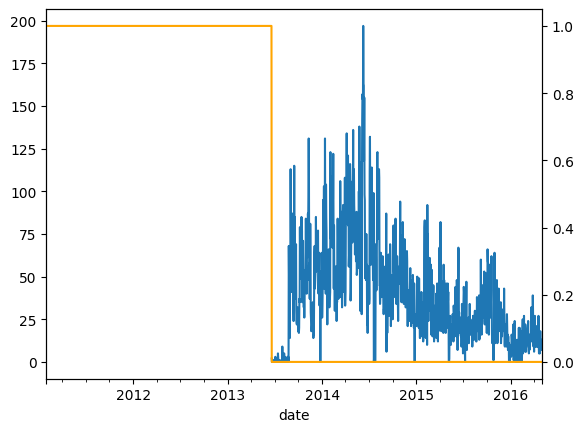

('FOODS_3_607', 'TX_1')


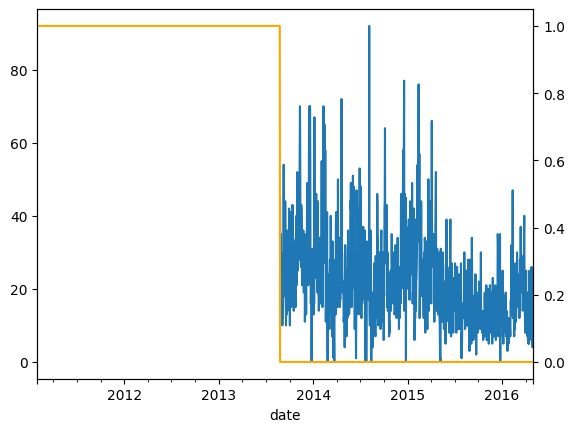

('FOODS_3_607', 'TX_2')


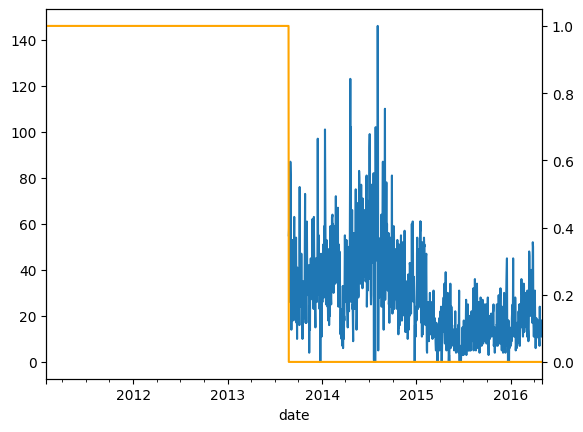

('FOODS_3_607', 'TX_3')


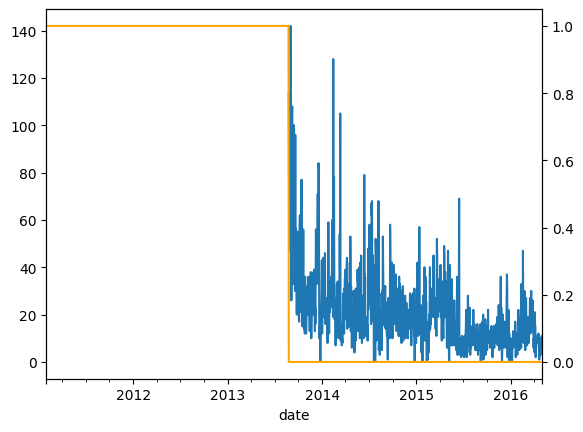

('FOODS_3_607', 'WI_3')


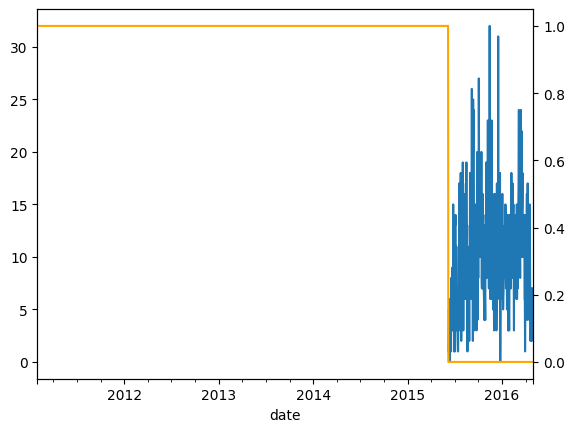

('FOODS_3_661', 'CA_3')


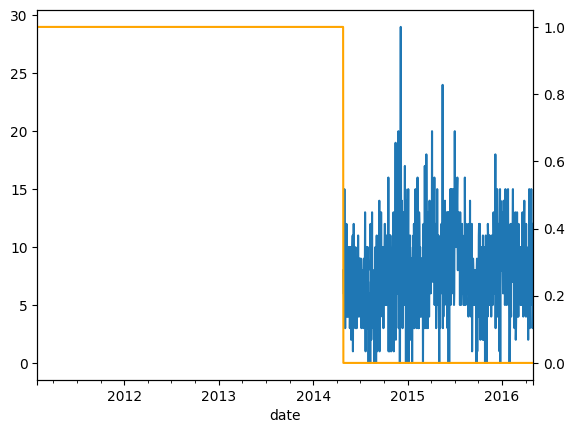

('FOODS_3_668', 'WI_1')


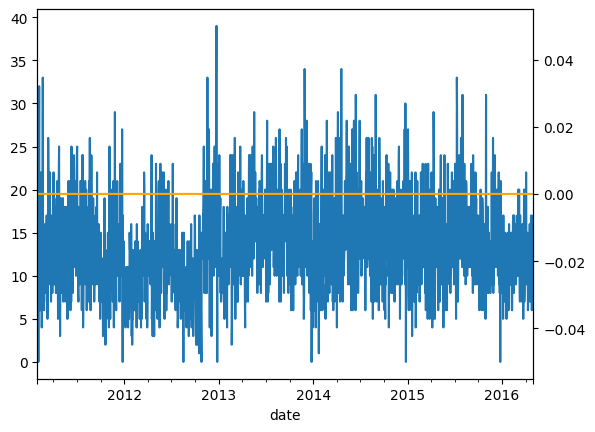

('FOODS_3_672', 'TX_2')


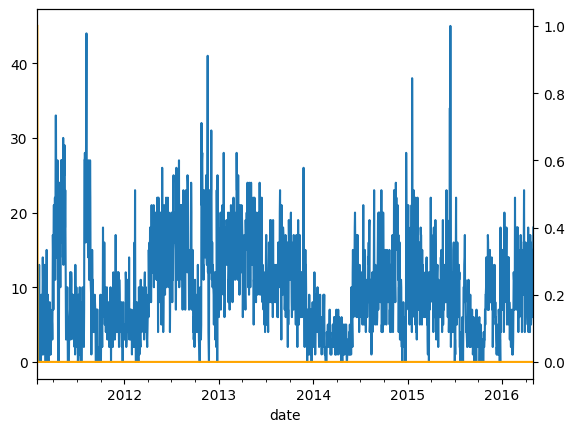

('FOODS_3_681', 'CA_1')


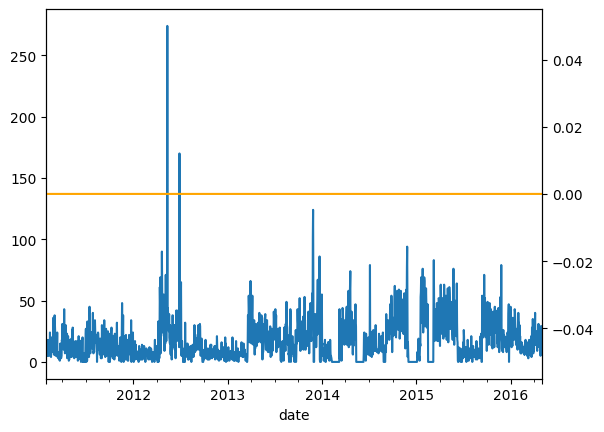

('FOODS_3_681', 'CA_3')


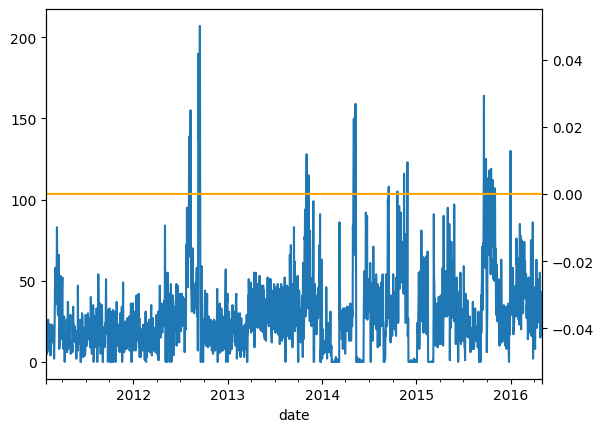

('FOODS_3_681', 'TX_1')


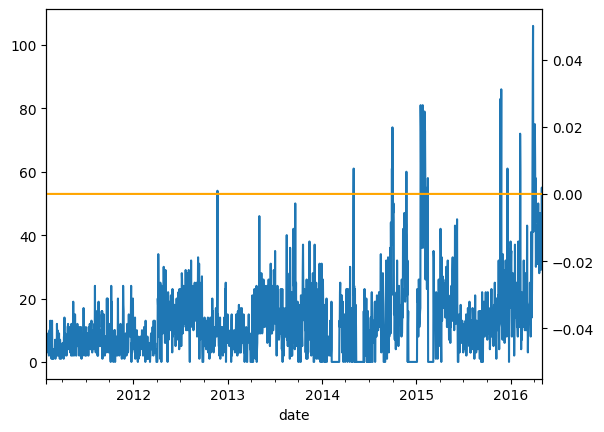

('FOODS_3_681', 'WI_3')


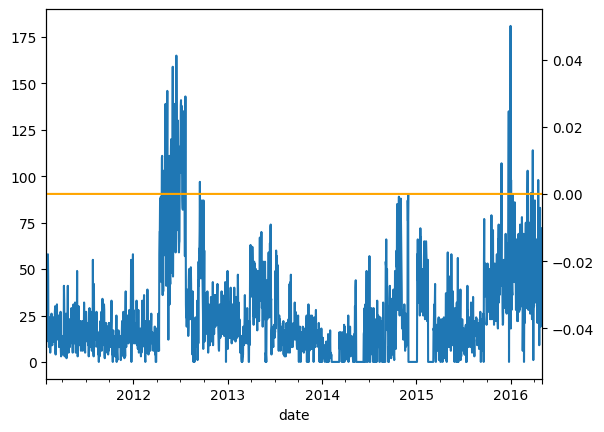

('FOODS_3_682', 'CA_3')


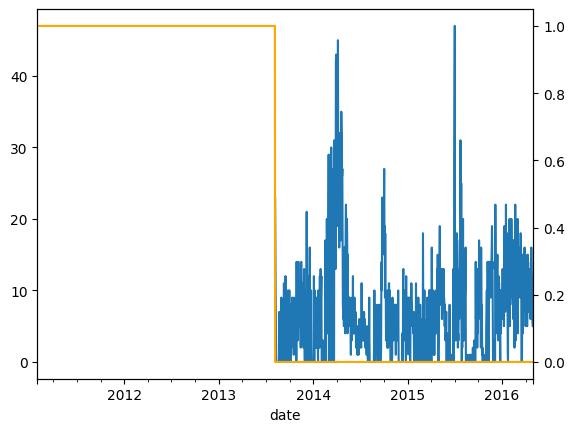

('FOODS_3_694', 'CA_1')


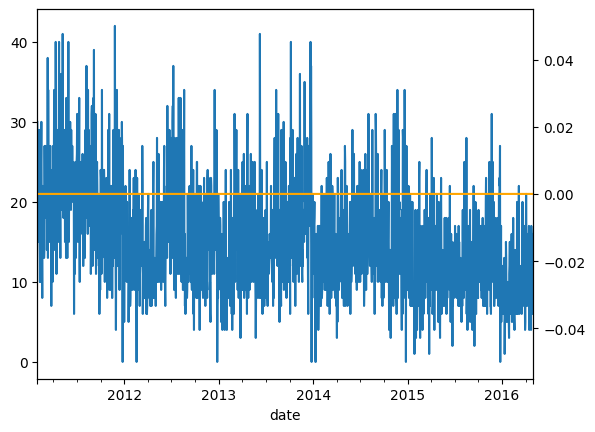

('FOODS_3_694', 'CA_3')


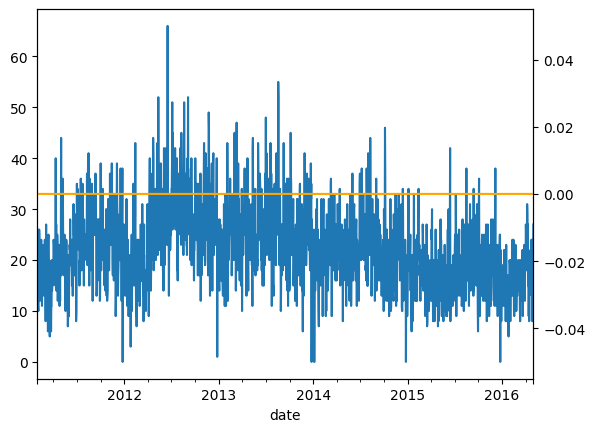

('FOODS_3_694', 'TX_1')


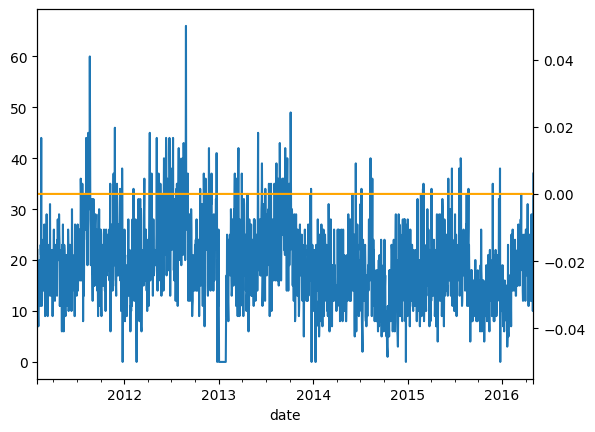

('FOODS_3_694', 'TX_2')


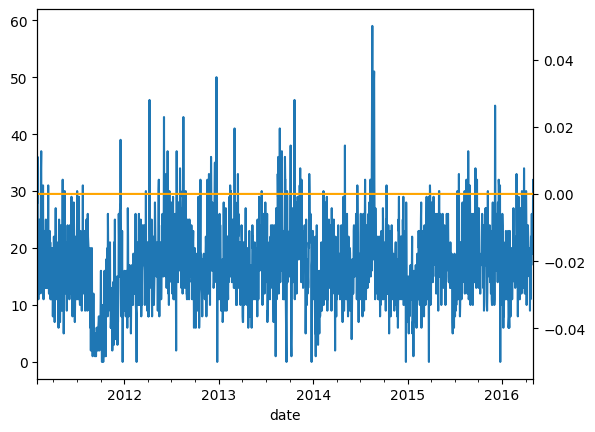

('FOODS_3_694', 'TX_3')


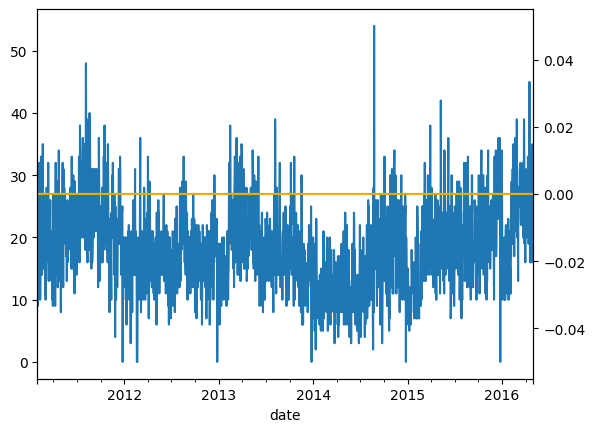

('FOODS_3_694', 'WI_1')


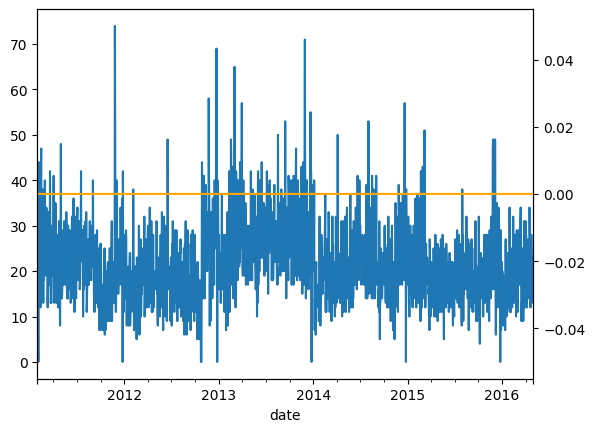

('FOODS_3_694', 'WI_2')


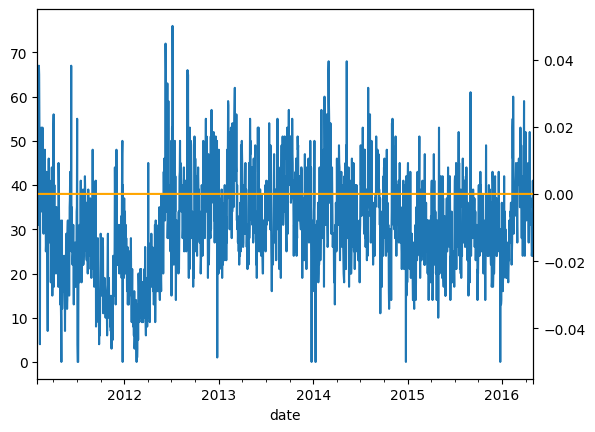

('FOODS_3_694', 'WI_3')


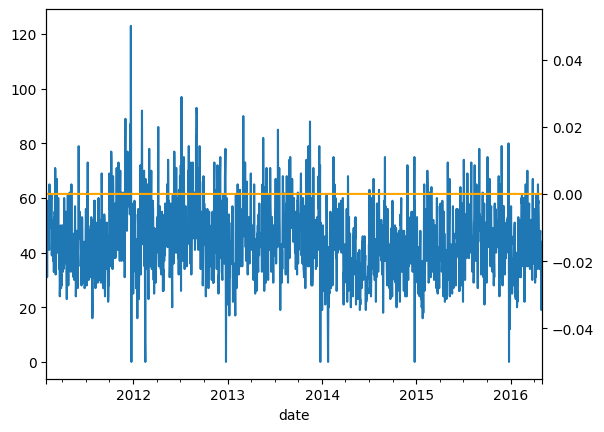

('FOODS_3_695', 'CA_3')


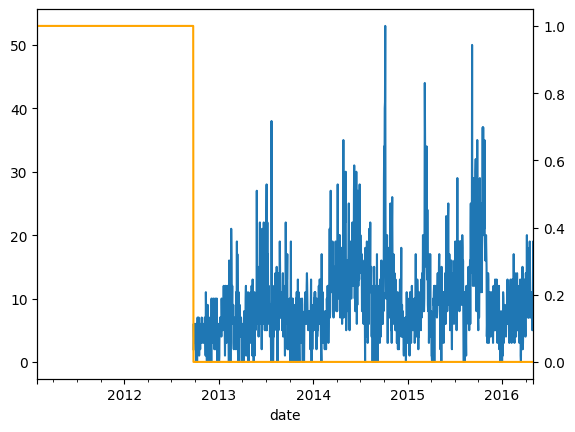

('FOODS_3_697', 'CA_1')


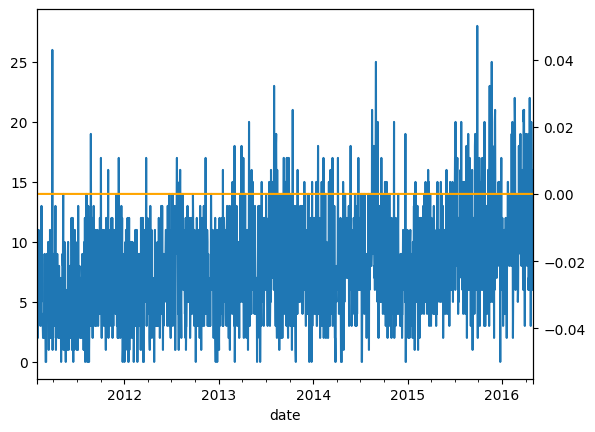

('FOODS_3_697', 'CA_2')


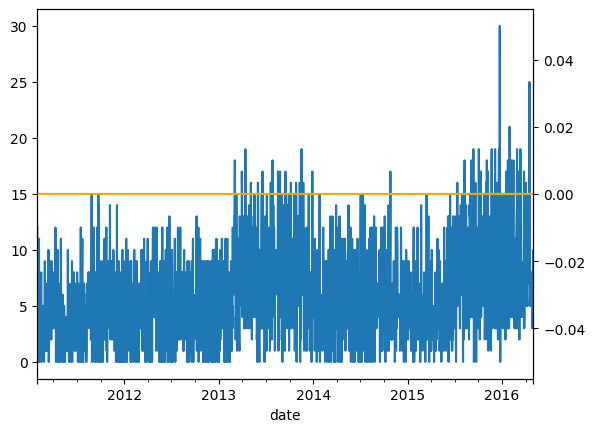

('FOODS_3_697', 'CA_3')


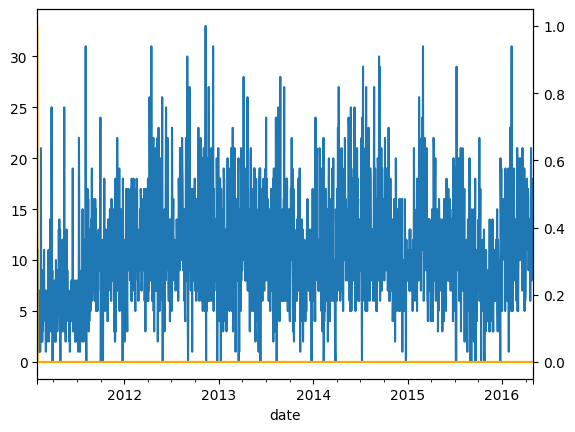

('FOODS_3_702', 'CA_3')


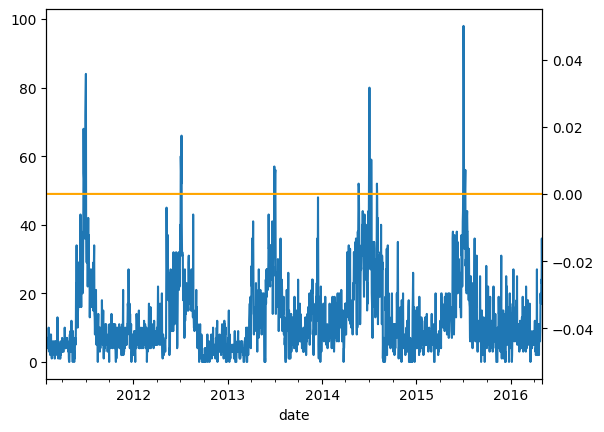

('FOODS_3_714', 'CA_1')


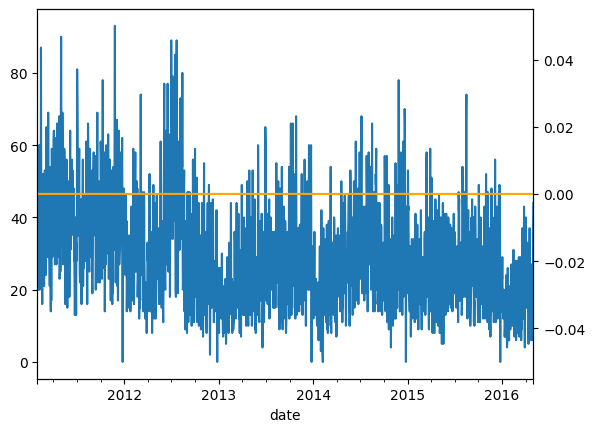

('FOODS_3_714', 'CA_2')


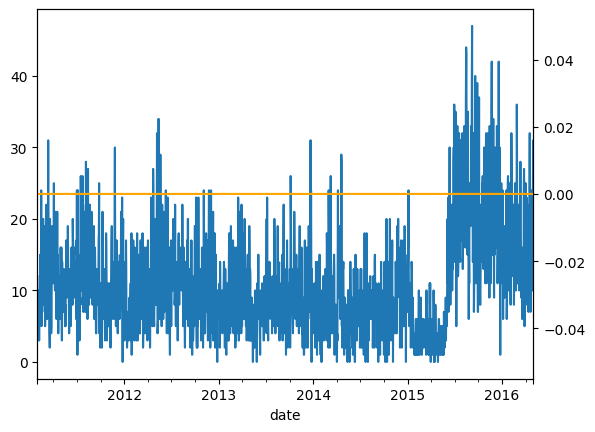

('FOODS_3_714', 'CA_3')


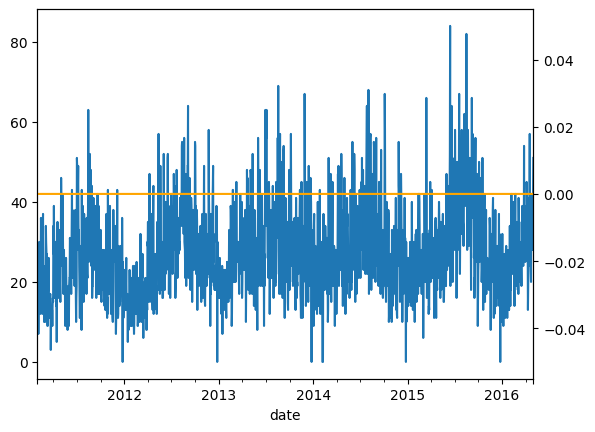

('FOODS_3_714', 'TX_1')


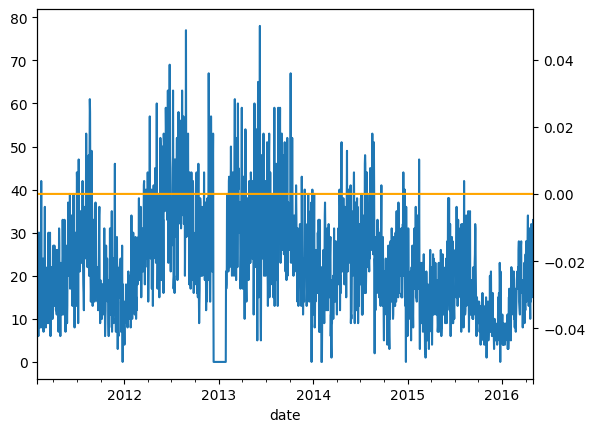

('FOODS_3_714', 'TX_2')


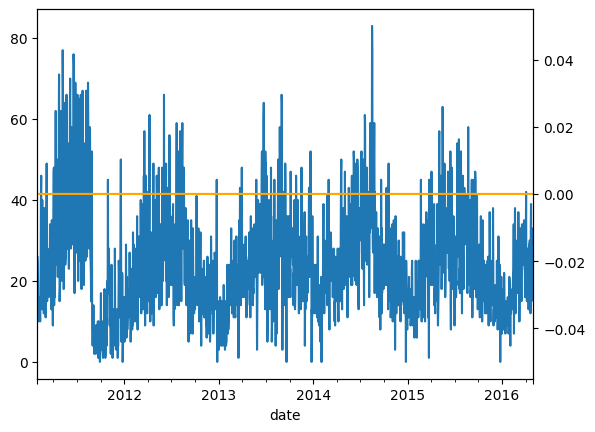

('FOODS_3_714', 'TX_3')


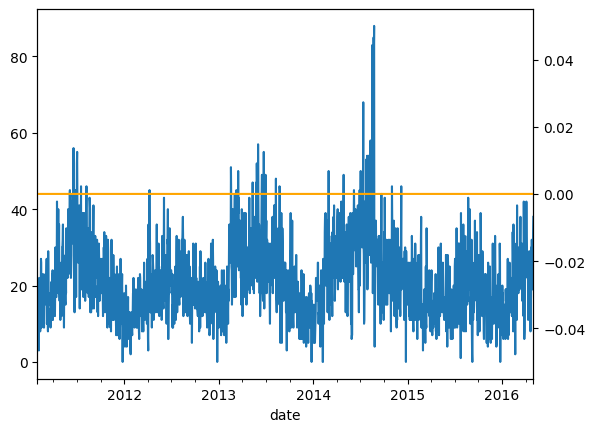

('FOODS_3_714', 'WI_1')


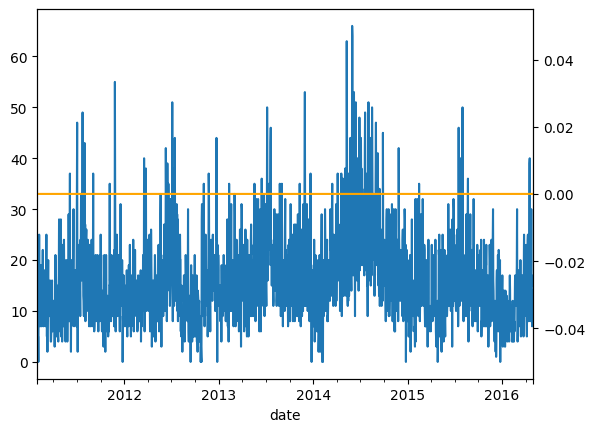

('FOODS_3_714', 'WI_2')


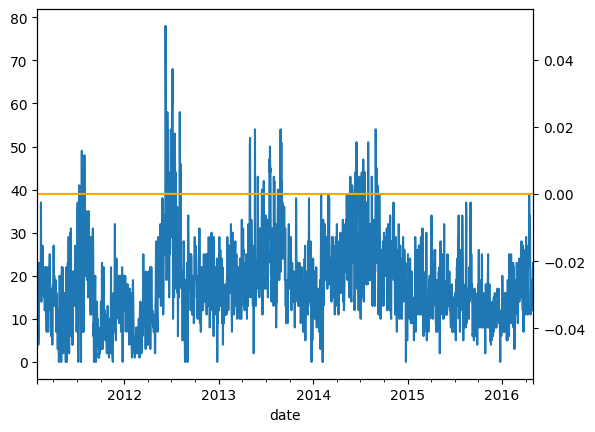

('FOODS_3_714', 'WI_3')


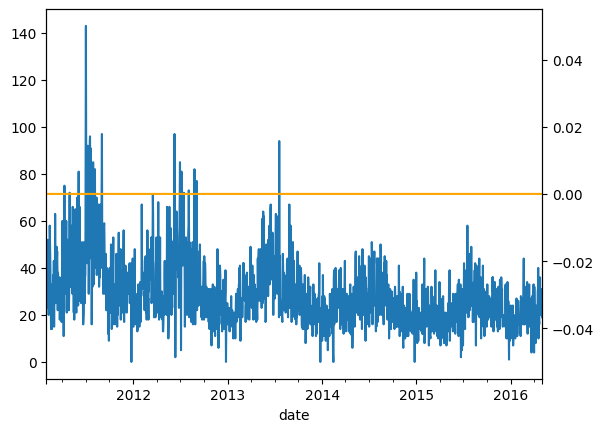

('FOODS_3_739', 'CA_1')


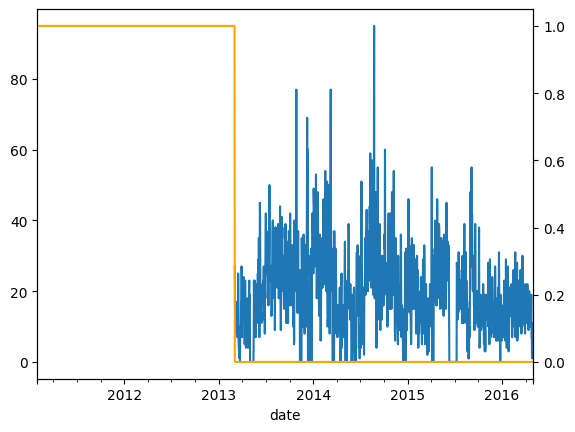

('FOODS_3_739', 'CA_2')


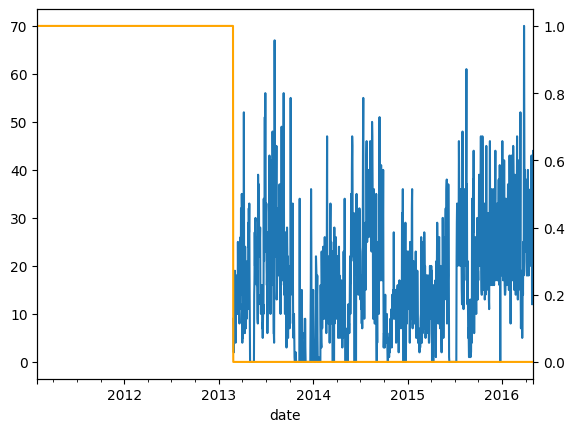

('FOODS_3_739', 'CA_3')


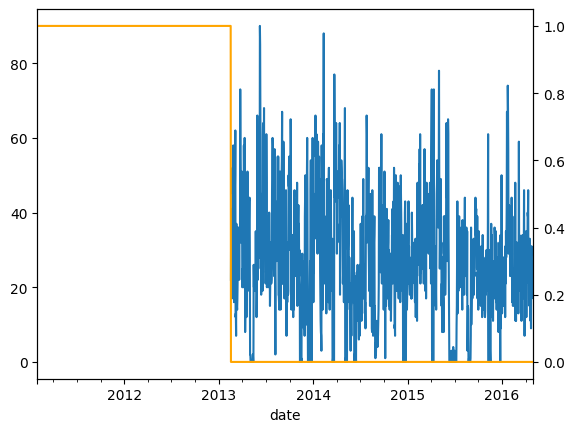

('FOODS_3_741', 'CA_1')


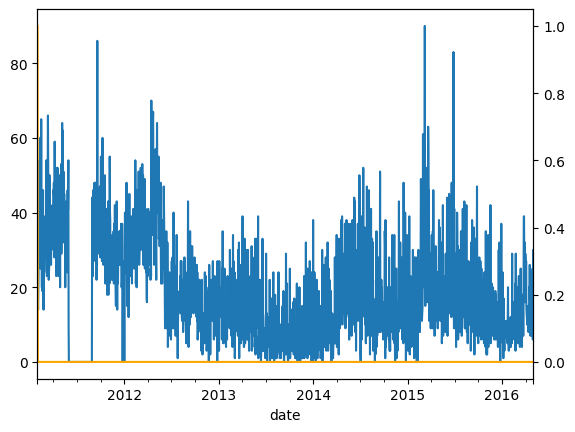

('FOODS_3_744', 'CA_1')


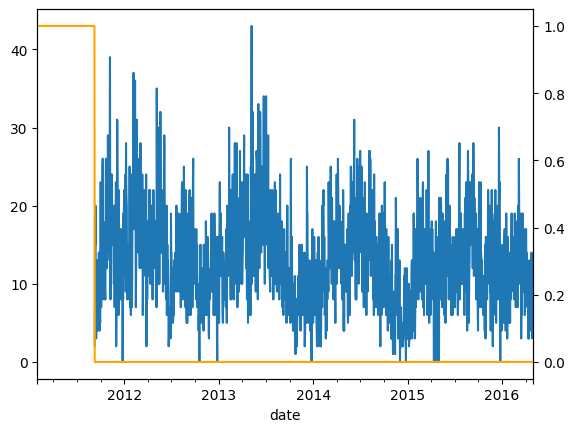

('FOODS_3_744', 'CA_3')


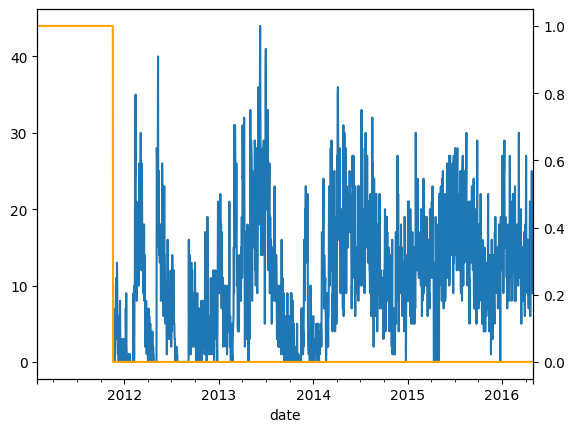

('FOODS_3_746', 'CA_3')


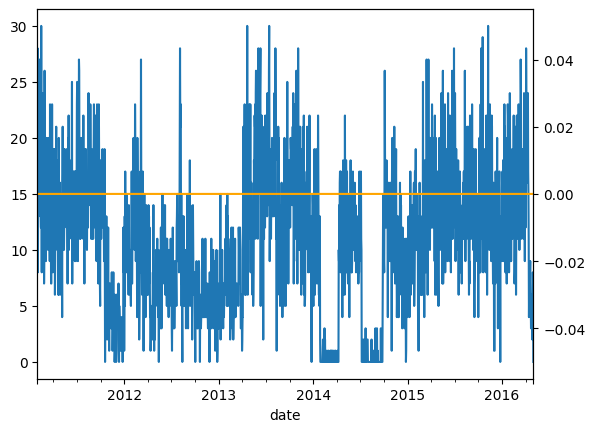

('FOODS_3_756', 'CA_3')


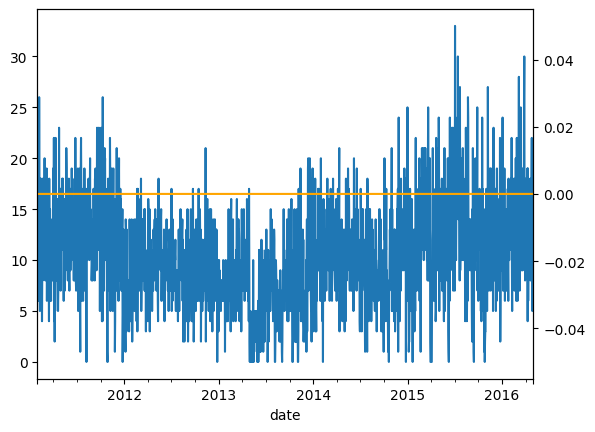

('FOODS_3_756', 'TX_2')


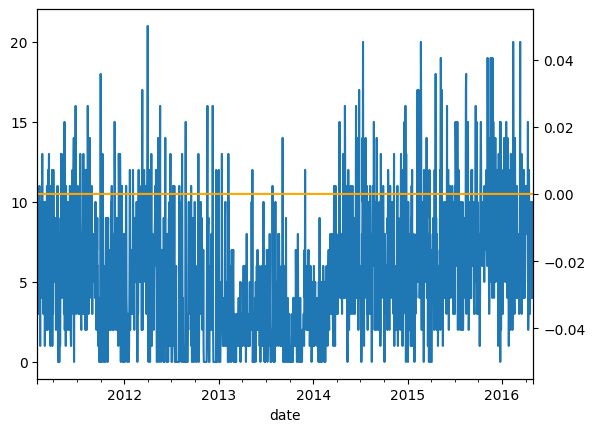

('FOODS_3_756', 'TX_3')


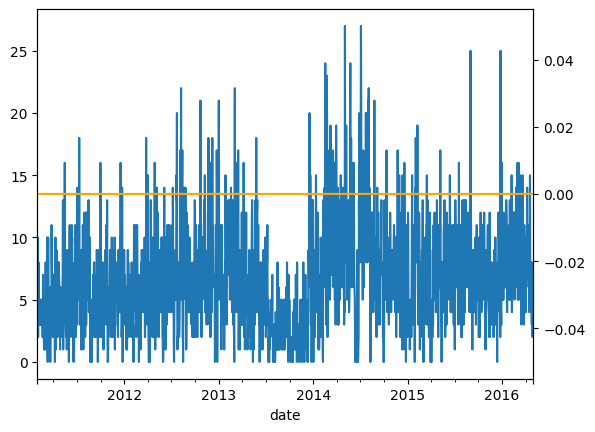

('FOODS_3_756', 'WI_2')


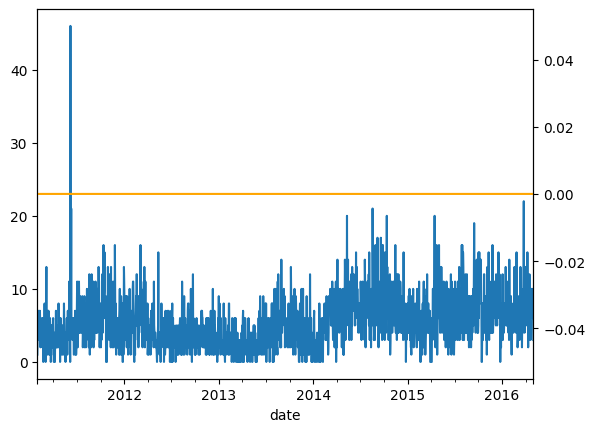

('FOODS_3_756', 'WI_3')


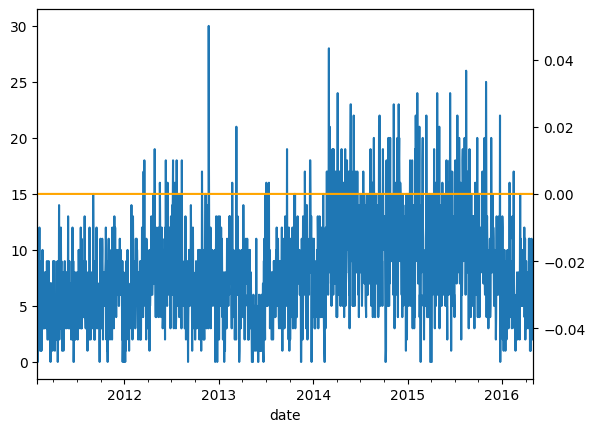

('FOODS_3_760', 'CA_1')


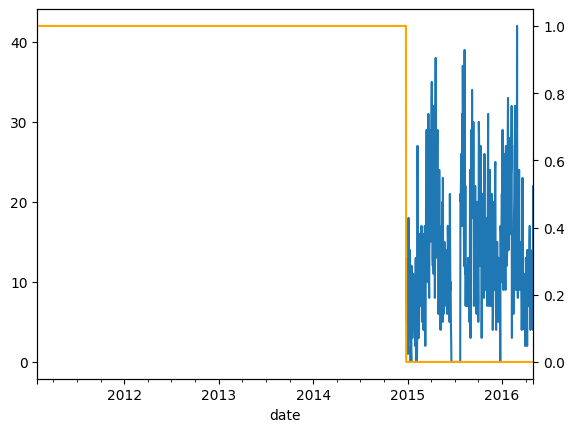

('FOODS_3_760', 'CA_2')


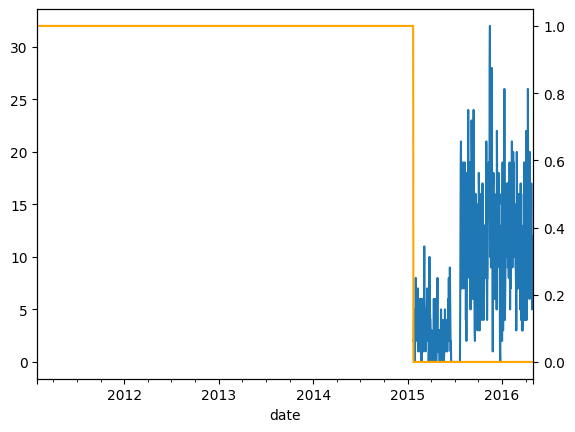

('FOODS_3_760', 'CA_3')


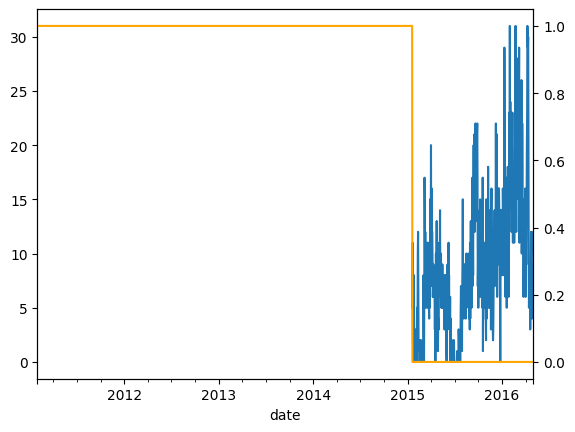

('FOODS_3_760', 'WI_2')


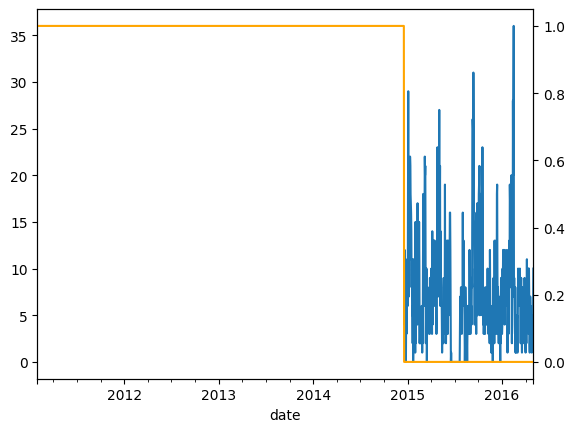

('FOODS_3_772', 'CA_3')


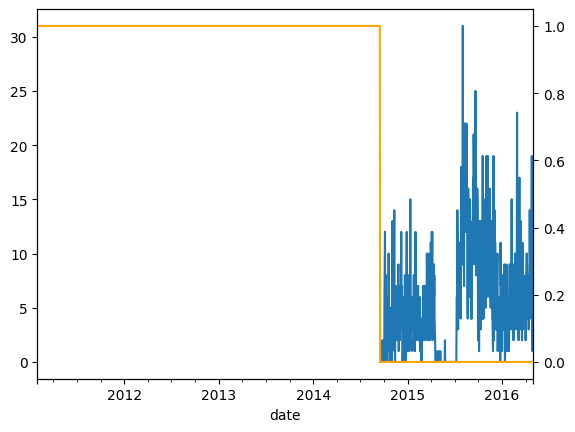

('FOODS_3_789', 'WI_2')


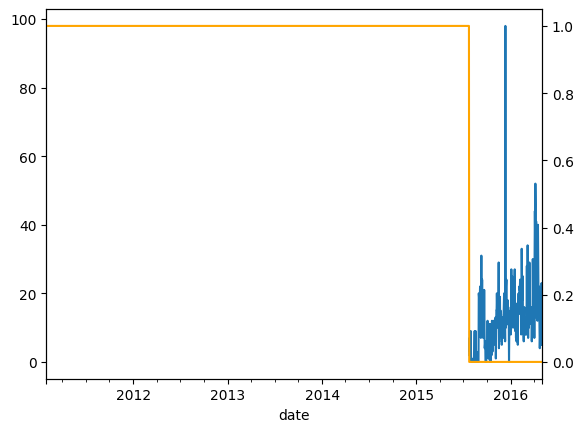

('FOODS_3_804', 'CA_2')


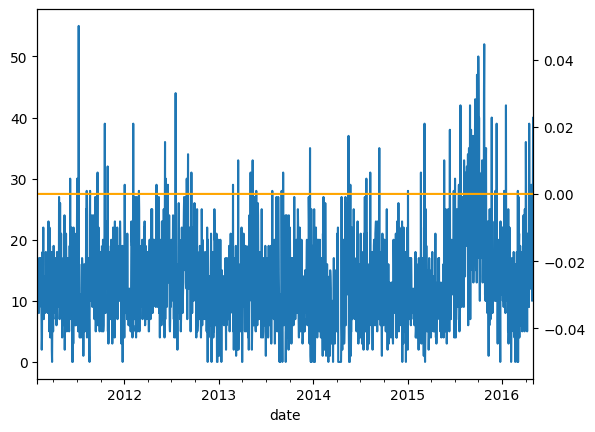

('FOODS_3_804', 'TX_1')


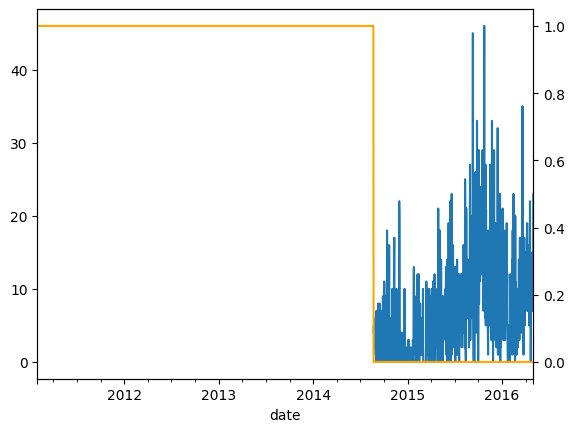

('FOODS_3_804', 'TX_2')


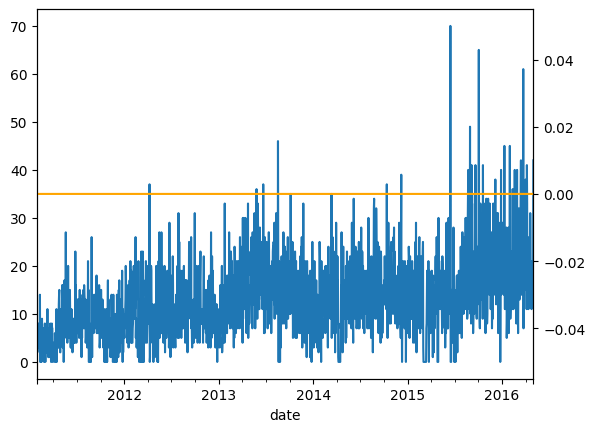

('FOODS_3_804', 'TX_3')


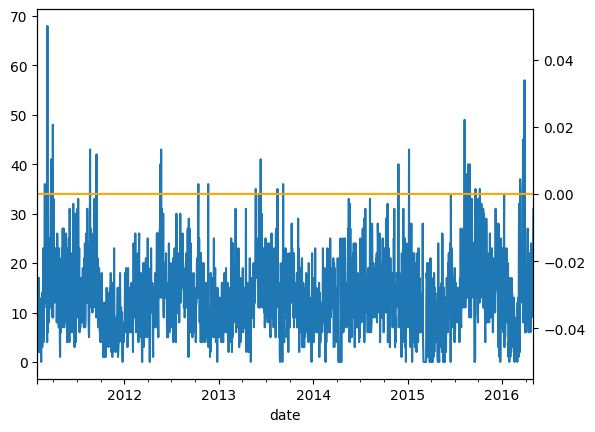

('FOODS_3_804', 'WI_2')


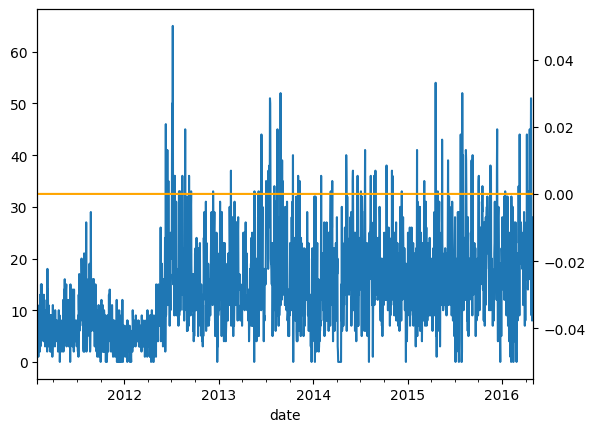

('FOODS_3_804', 'WI_3')


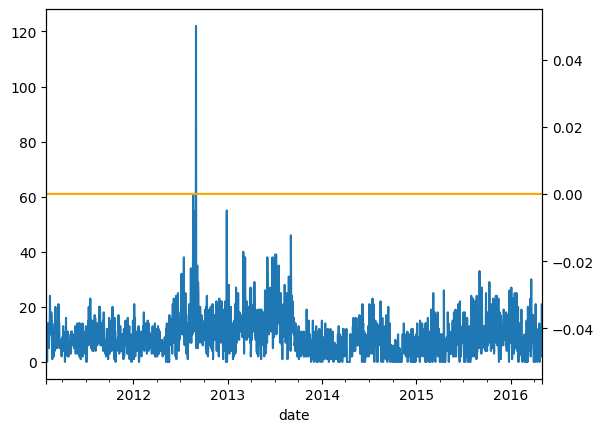

('FOODS_3_811', 'CA_3')


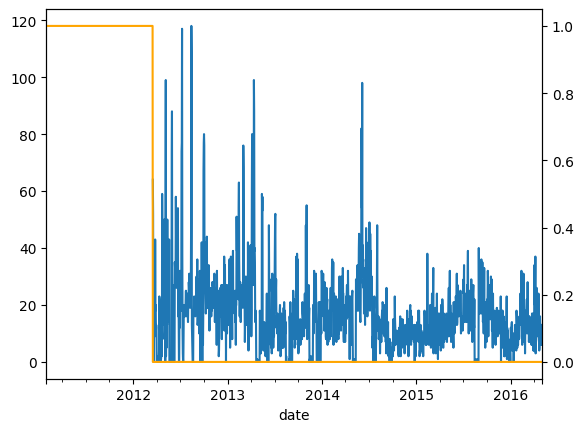

('FOODS_3_811', 'TX_1')


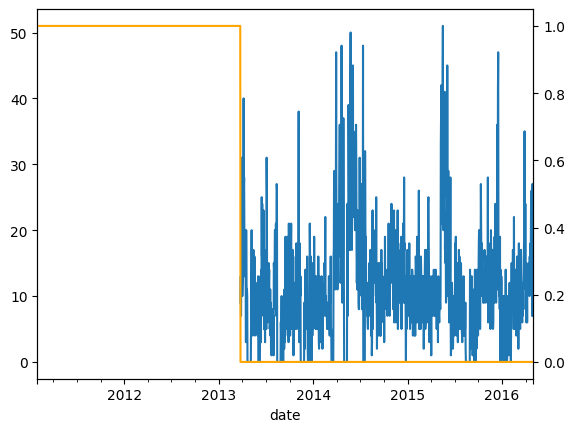

('FOODS_3_811', 'WI_2')


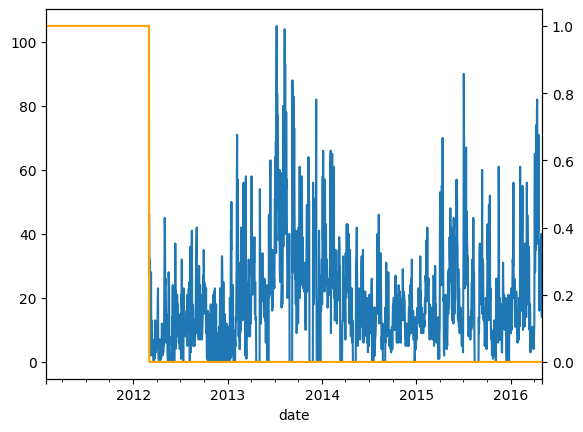

('FOODS_3_811', 'WI_3')


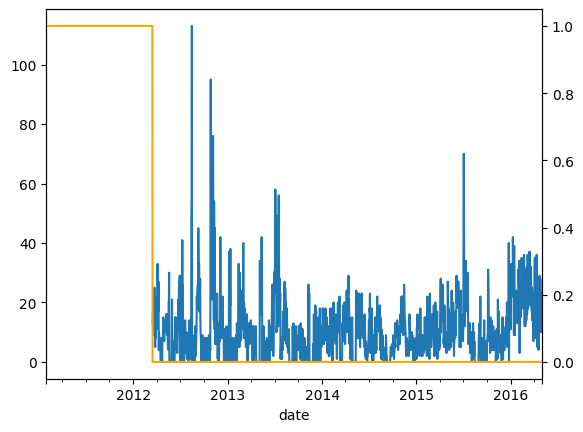

In [21]:
for c in sales_pivoted.columns:
    series = sales_pivoted[c]
    # if series.dropna().iloc[0] == 0:
    print(c)
    series.plot()
    ax2 = plt.twinx()
    full_mask[c].astype(int).plot(ax=ax2,color='orange')
    plt.show()